In [30]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [31]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full_corrected_w_age.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected_w_age.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full_corrected_w_age.csv
Name of the anagraphic dataset: labels.csv


In [32]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    return data, labels

In [33]:
def print_feats(feats):
    cur, idx = [], 0
    for feat in feats:
        cur.append(str(feat))
        idx += 1
        if (idx % 5) == 0:
            print(', '.join(cur) + ',')
            cur = []
    if len(cur) > 0:
        print(', '.join(cur))

In [34]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]

In [35]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]


# ML Approach

In [36]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(500):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    return plot_compounded(results, feat_to_predict)


### Full Data

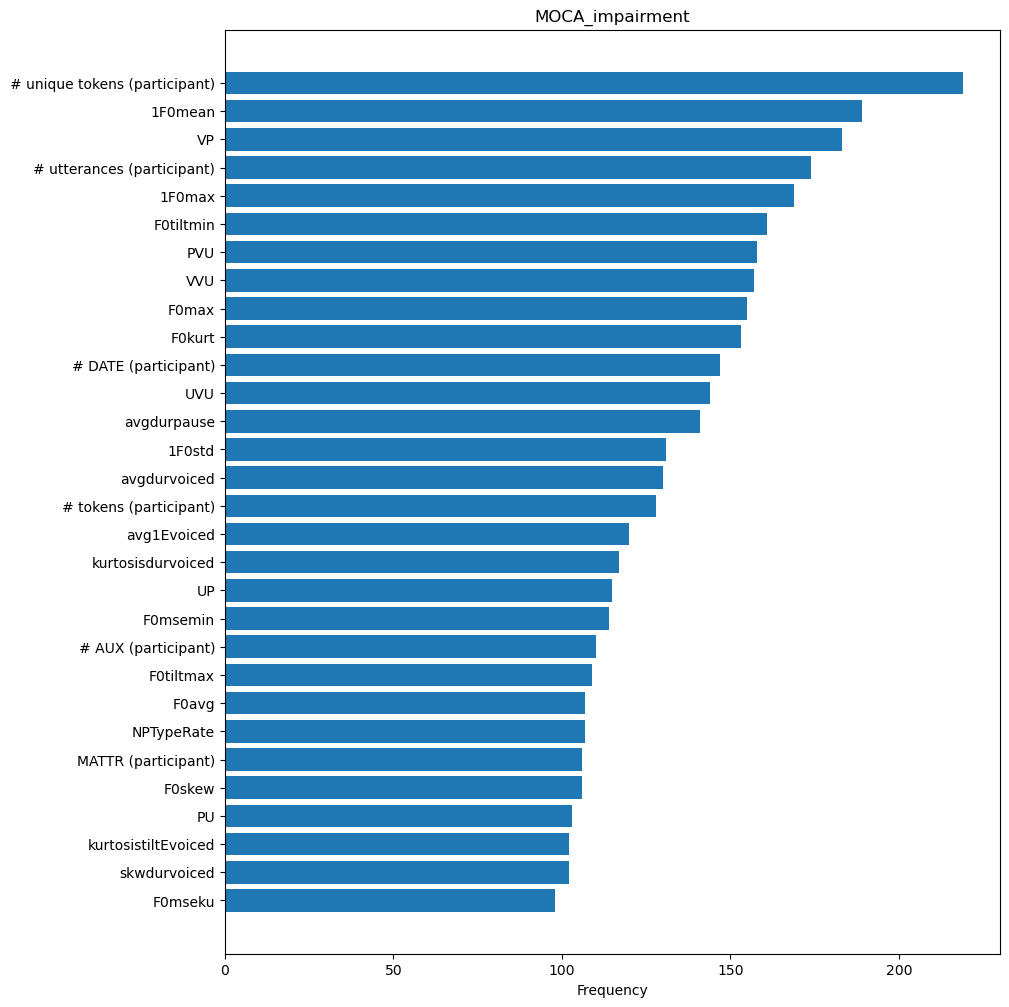

# unique tokens (participant), 1F0mean, VP, # utterances (participant), 1F0max,
F0tiltmin, PVU, VVU, F0max, F0kurt,
# DATE (participant), UVU, avgdurpause, 1F0std, avgdurvoiced,
# tokens (participant), avg1Evoiced, kurtosisdurvoiced, UP, F0msemin,
# AUX (participant), F0tiltmax, F0avg, NPTypeRate, MATTR (participant),
F0skew, PU, kurtosistiltEvoiced, skwdurvoiced, F0mseku,


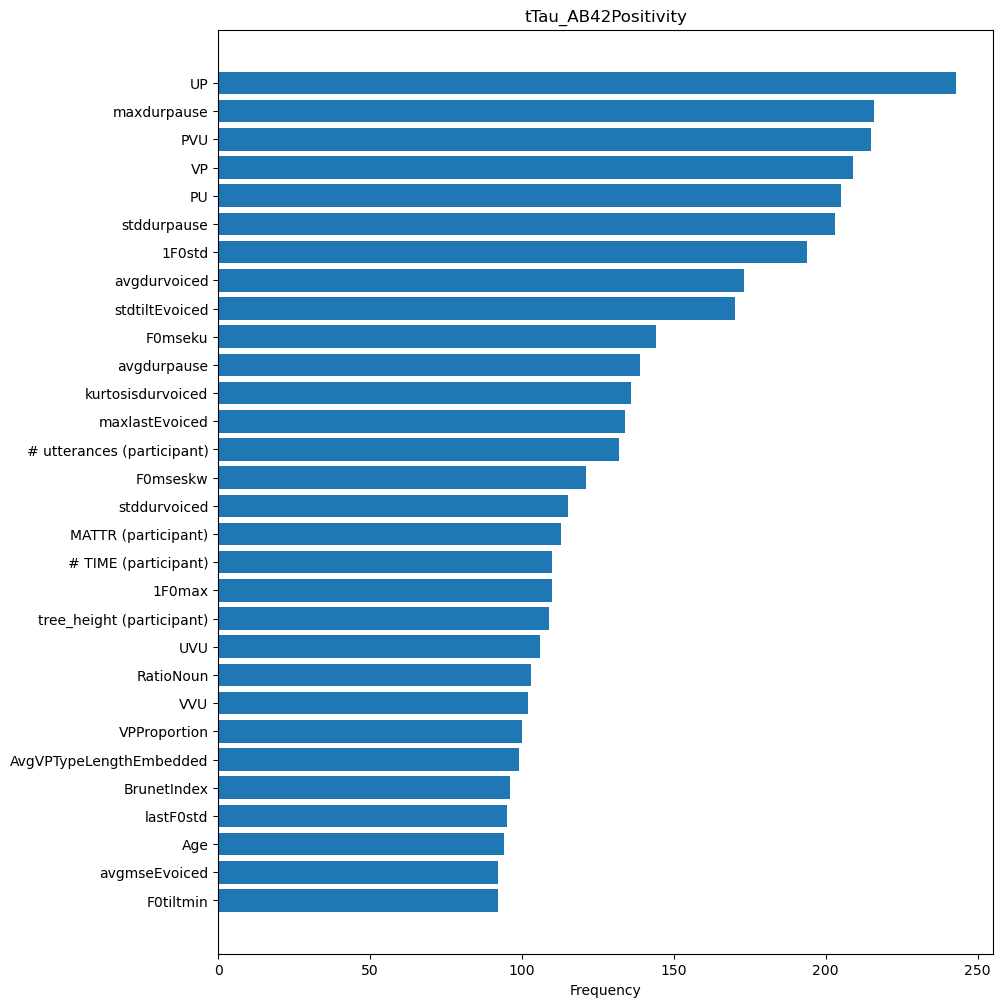

UP, maxdurpause, PVU, VP, PU,
stddurpause, 1F0std, avgdurvoiced, stdtiltEvoiced, F0mseku,
avgdurpause, kurtosisdurvoiced, maxlastEvoiced, # utterances (participant), F0mseskw,
stddurvoiced, MATTR (participant), # TIME (participant), 1F0max, tree_height (participant),
UVU, RatioNoun, VVU, VPProportion, AvgVPTypeLengthEmbedded,
BrunetIndex, lastF0std, Age, avgmseEvoiced, F0tiltmin,


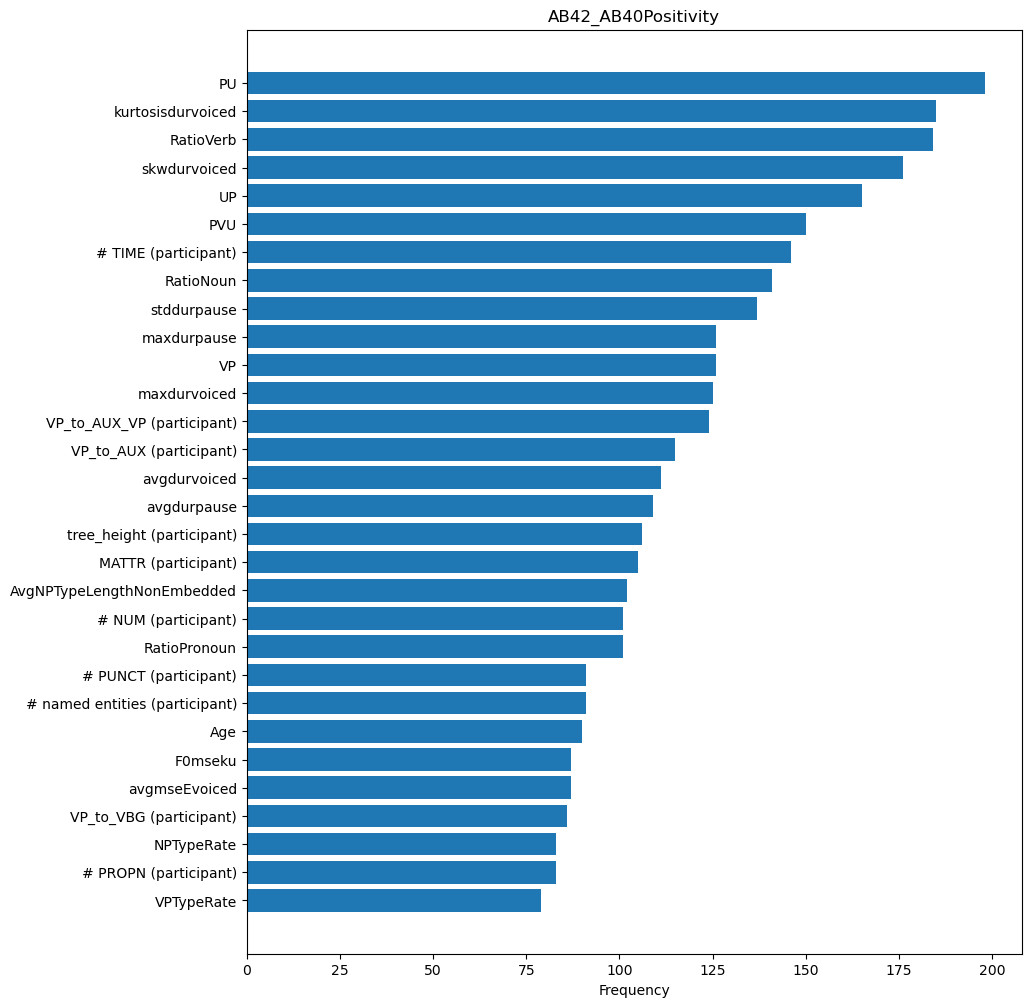

PU, kurtosisdurvoiced, RatioVerb, skwdurvoiced, UP,
PVU, # TIME (participant), RatioNoun, stddurpause, maxdurpause,
VP, maxdurvoiced, VP_to_AUX_VP (participant), VP_to_AUX (participant), avgdurvoiced,
avgdurpause, tree_height (participant), MATTR (participant), AvgNPTypeLengthNonEmbedded, # NUM (participant),
RatioPronoun, # PUNCT (participant), # named entities (participant), Age, F0mseku,
avgmseEvoiced, VP_to_VBG (participant), NPTypeRate, # PROPN (participant), VPTypeRate,


In [37]:
MOCA_ML_FULL_COMPUTED_FEATURES = ml_analysis('MOCA_impairment')
TTAU_ML_FULL_COMPUTED_FEATURES = ml_analysis('tTau_AB42Positivity')
AB42_ML_FULL_COMPUTED_FEATURES = ml_analysis('AB42_AB40Positivity')

### No Audio

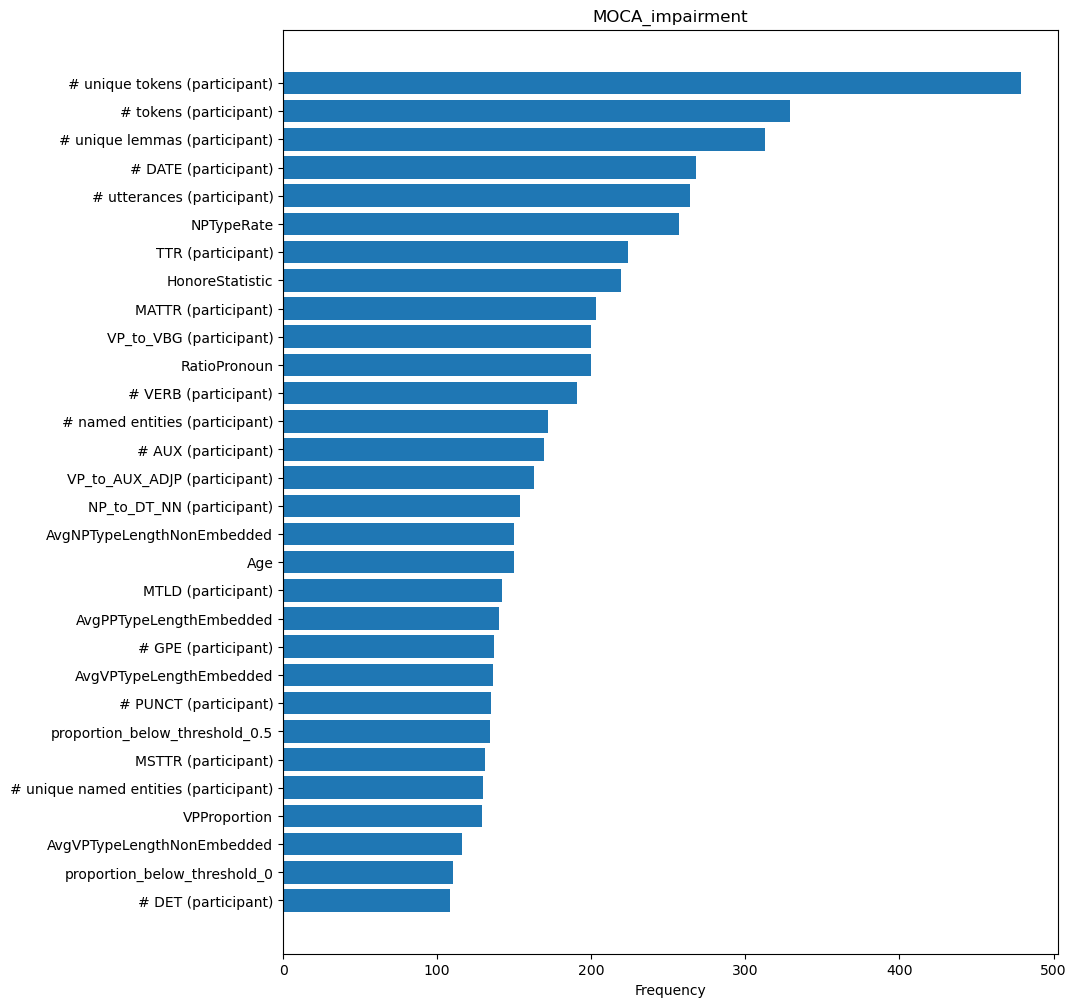

# unique tokens (participant), # tokens (participant), # unique lemmas (participant), # DATE (participant), # utterances (participant),
NPTypeRate, TTR (participant), HonoreStatistic, MATTR (participant), VP_to_VBG (participant),
RatioPronoun, # VERB (participant), # named entities (participant), # AUX (participant), VP_to_AUX_ADJP (participant),
NP_to_DT_NN (participant), AvgNPTypeLengthNonEmbedded, Age, MTLD (participant), AvgPPTypeLengthEmbedded,
# GPE (participant), AvgVPTypeLengthEmbedded, # PUNCT (participant), proportion_below_threshold_0.5, MSTTR (participant),
# unique named entities (participant), VPProportion, AvgVPTypeLengthNonEmbedded, proportion_below_threshold_0, # DET (participant),


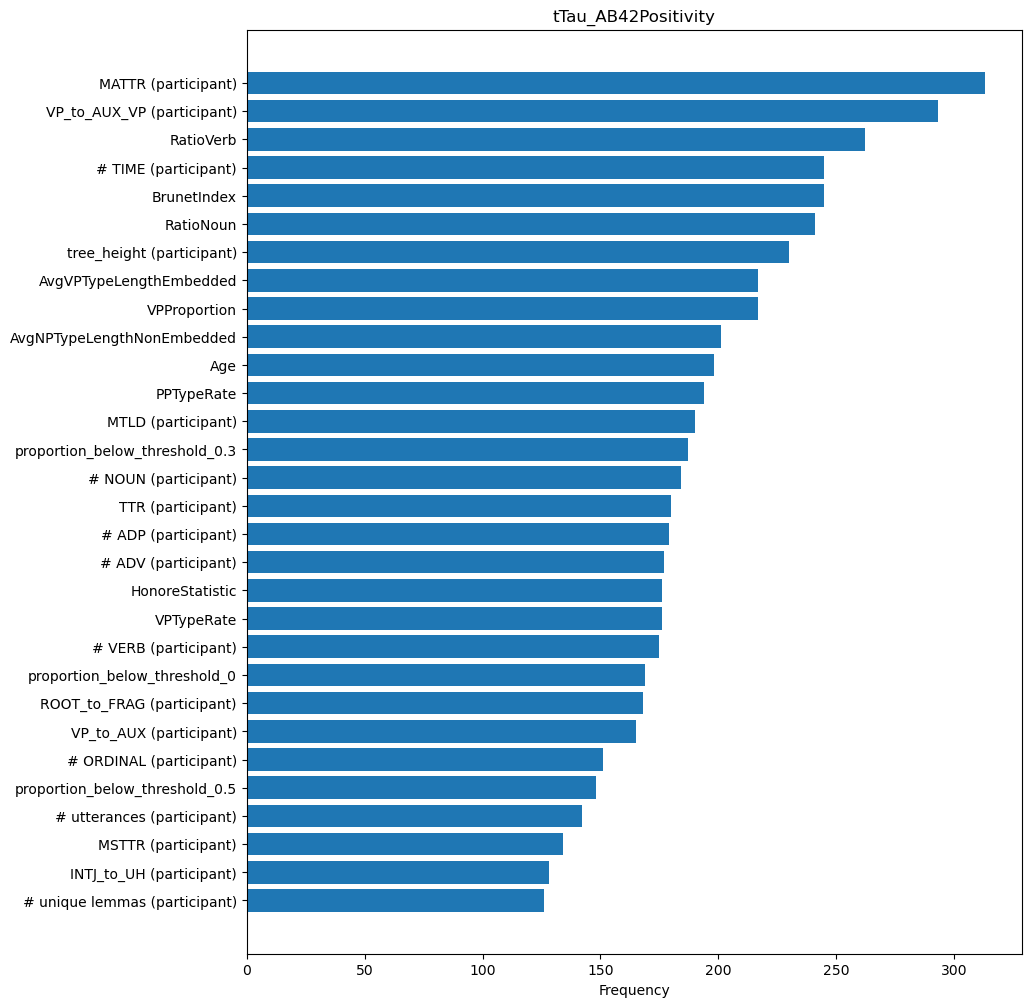

MATTR (participant), VP_to_AUX_VP (participant), RatioVerb, # TIME (participant), BrunetIndex,
RatioNoun, tree_height (participant), AvgVPTypeLengthEmbedded, VPProportion, AvgNPTypeLengthNonEmbedded,
Age, PPTypeRate, MTLD (participant), proportion_below_threshold_0.3, # NOUN (participant),
TTR (participant), # ADP (participant), # ADV (participant), HonoreStatistic, VPTypeRate,
# VERB (participant), proportion_below_threshold_0, ROOT_to_FRAG (participant), VP_to_AUX (participant), # ORDINAL (participant),
proportion_below_threshold_0.5, # utterances (participant), MSTTR (participant), INTJ_to_UH (participant), # unique lemmas (participant),


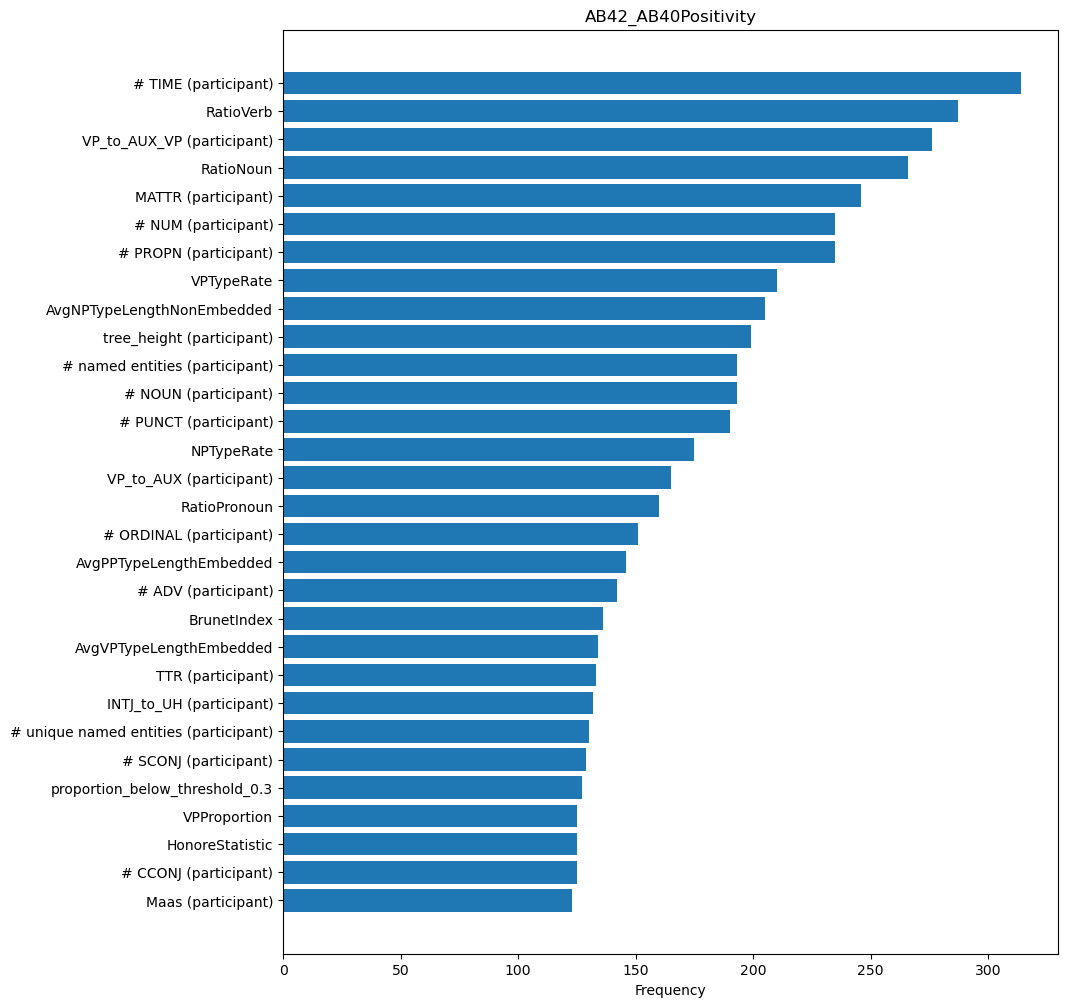

# TIME (participant), RatioVerb, VP_to_AUX_VP (participant), RatioNoun, MATTR (participant),
# NUM (participant), # PROPN (participant), VPTypeRate, AvgNPTypeLengthNonEmbedded, tree_height (participant),
# named entities (participant), # NOUN (participant), # PUNCT (participant), NPTypeRate, VP_to_AUX (participant),
RatioPronoun, # ORDINAL (participant), AvgPPTypeLengthEmbedded, # ADV (participant), BrunetIndex,
AvgVPTypeLengthEmbedded, TTR (participant), INTJ_to_UH (participant), # unique named entities (participant), # SCONJ (participant),
proportion_below_threshold_0.3, VPProportion, HonoreStatistic, # CCONJ (participant), Maas (participant),


In [38]:
MOCA_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('MOCA_impairment', audio=False)
TTAU_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('tTau_AB42Positivity', audio=False)
AB42_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('AB42_AB40Positivity', audio=False)

# Statistical Approach

In [39]:
def get_topK(X, y, cols, score_func, k=32):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    # Obtain the scores for all the features
    scores = list(select.fit(X, y).scores_)
    # Associate each score to the feature that is related to
    n_scores = list(zip(scores, [i for i in range(len(scores))]))
    # Sort the scores from highest to lowest
    n_scores.sort(key=lambda x: x[0], reverse=True)
    # Retrieve scores and features indexes
    scores, pos = zip(*n_scores)
    # Save top-k scores and their feature names
    top_scores.append(list(scores[:k]))
    top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [40]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    return plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Full Data

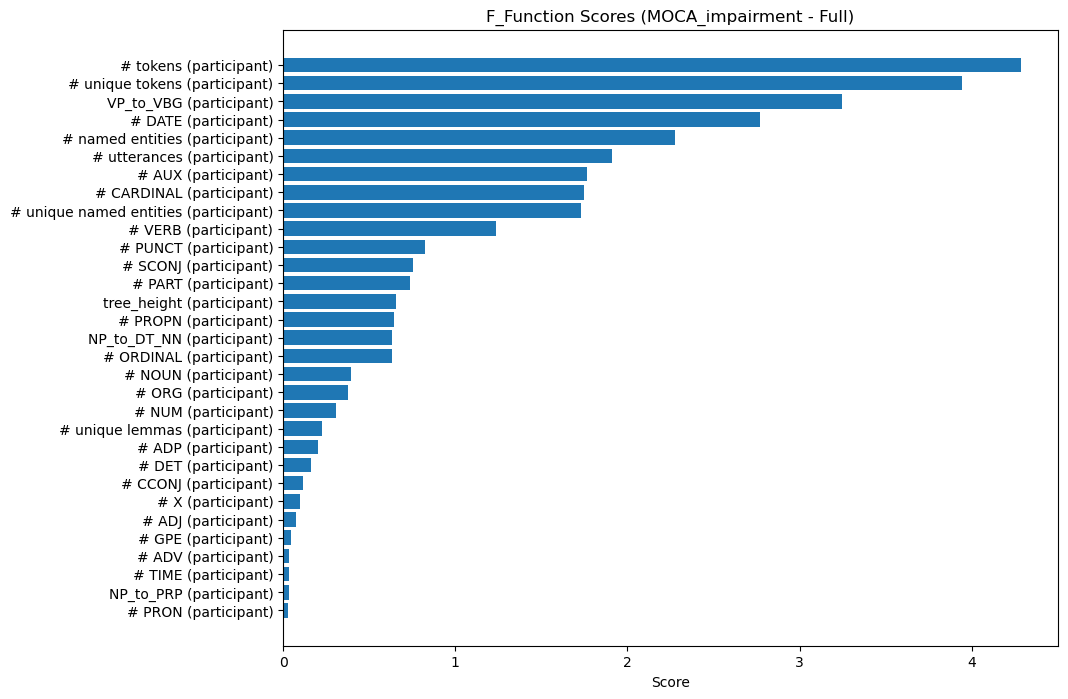

# tokens (participant), # unique tokens (participant), VP_to_VBG (participant), # DATE (participant), # named entities (participant),
# utterances (participant), # AUX (participant), # CARDINAL (participant), # unique named entities (participant), # VERB (participant),
# PUNCT (participant), # SCONJ (participant), # PART (participant), tree_height (participant), # PROPN (participant),
NP_to_DT_NN (participant), # ORDINAL (participant), # NOUN (participant), # ORG (participant), # NUM (participant),
# unique lemmas (participant), # ADP (participant), # DET (participant), # CCONJ (participant), # X (participant),
# ADJ (participant), # GPE (participant), # ADV (participant), # TIME (participant), NP_to_PRP (participant),
# PRON (participant)


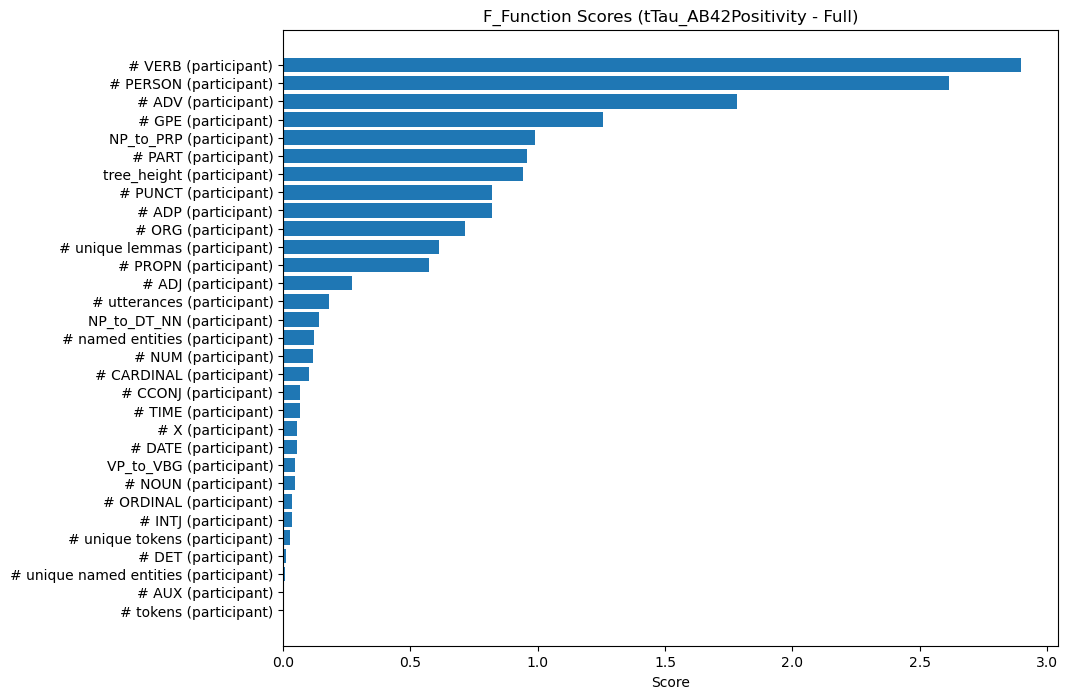

# VERB (participant), # PERSON (participant), # ADV (participant), # GPE (participant), NP_to_PRP (participant),
# PART (participant), tree_height (participant), # PUNCT (participant), # ADP (participant), # ORG (participant),
# unique lemmas (participant), # PROPN (participant), # ADJ (participant), # utterances (participant), NP_to_DT_NN (participant),
# named entities (participant), # NUM (participant), # CARDINAL (participant), # CCONJ (participant), # TIME (participant),
# X (participant), # DATE (participant), VP_to_VBG (participant), # NOUN (participant), # ORDINAL (participant),
# INTJ (participant), # unique tokens (participant), # DET (participant), # unique named entities (participant), # AUX (participant),
# tokens (participant)


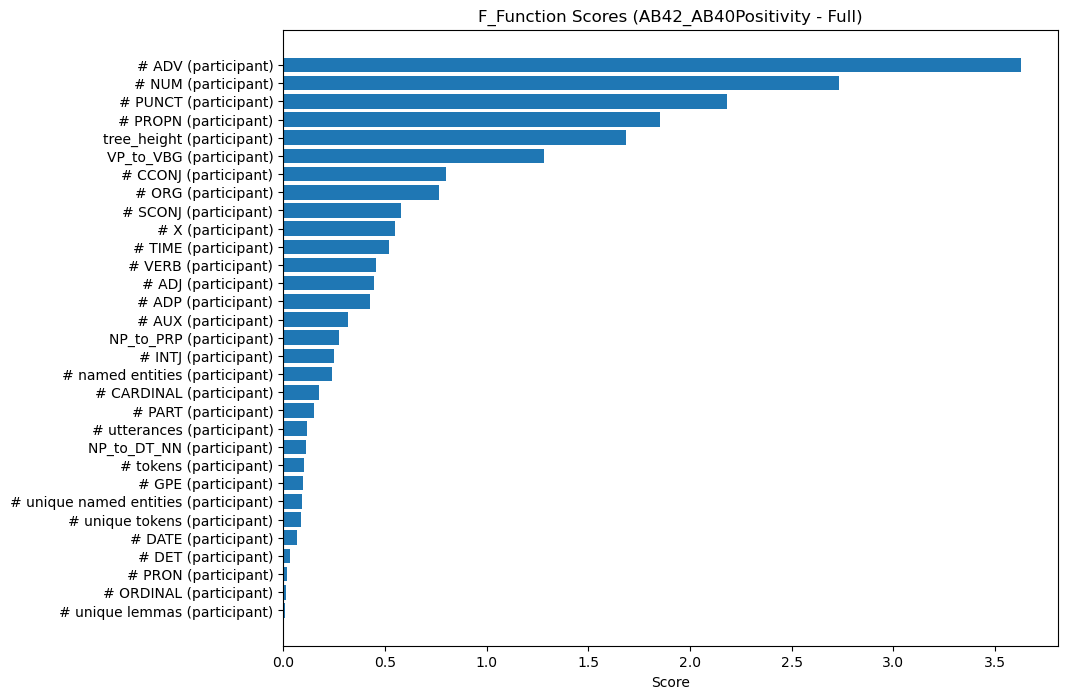

# ADV (participant), # NUM (participant), # PUNCT (participant), # PROPN (participant), tree_height (participant),
VP_to_VBG (participant), # CCONJ (participant), # ORG (participant), # SCONJ (participant), # X (participant),
# TIME (participant), # VERB (participant), # ADJ (participant), # ADP (participant), # AUX (participant),
NP_to_PRP (participant), # INTJ (participant), # named entities (participant), # CARDINAL (participant), # PART (participant),
# utterances (participant), NP_to_DT_NN (participant), # tokens (participant), # GPE (participant), # unique named entities (participant),
# unique tokens (participant), # DATE (participant), # DET (participant), # PRON (participant), # ORDINAL (participant),
# unique lemmas (participant)


In [41]:
MOCA_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('MOCA_impairment')
TTAU_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('tTau_AB42Positivity')
AB42_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('AB42_AB40Positivity')

### No Audio

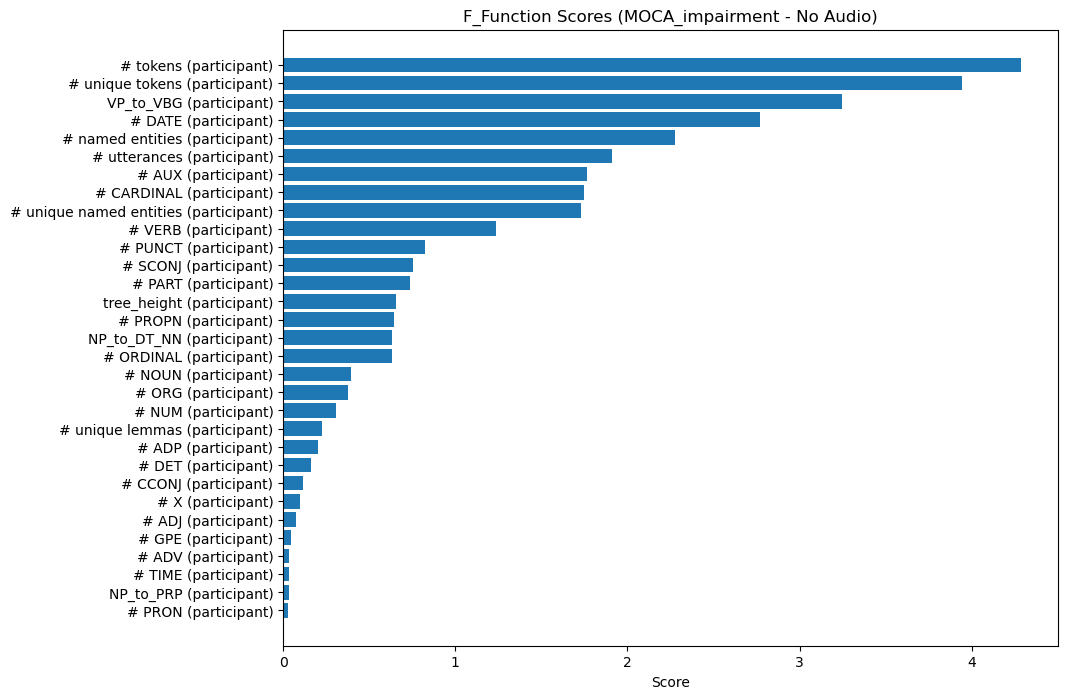

# tokens (participant), # unique tokens (participant), VP_to_VBG (participant), # DATE (participant), # named entities (participant),
# utterances (participant), # AUX (participant), # CARDINAL (participant), # unique named entities (participant), # VERB (participant),
# PUNCT (participant), # SCONJ (participant), # PART (participant), tree_height (participant), # PROPN (participant),
NP_to_DT_NN (participant), # ORDINAL (participant), # NOUN (participant), # ORG (participant), # NUM (participant),
# unique lemmas (participant), # ADP (participant), # DET (participant), # CCONJ (participant), # X (participant),
# ADJ (participant), # GPE (participant), # ADV (participant), # TIME (participant), NP_to_PRP (participant),
# PRON (participant)


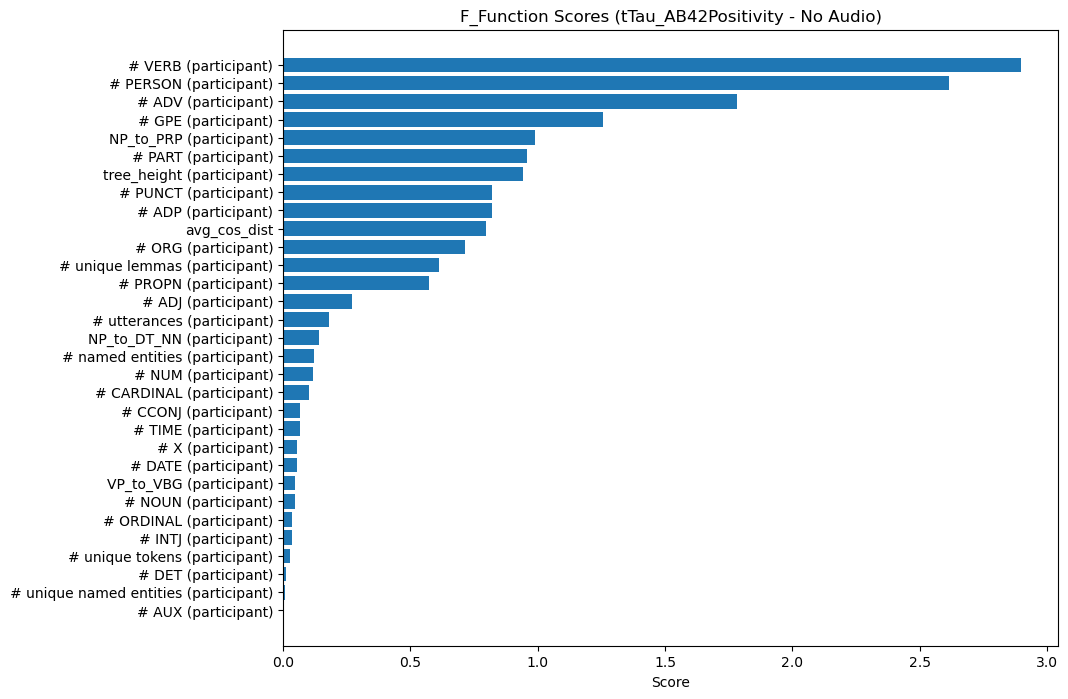

# VERB (participant), # PERSON (participant), # ADV (participant), # GPE (participant), NP_to_PRP (participant),
# PART (participant), tree_height (participant), # PUNCT (participant), # ADP (participant), avg_cos_dist,
# ORG (participant), # unique lemmas (participant), # PROPN (participant), # ADJ (participant), # utterances (participant),
NP_to_DT_NN (participant), # named entities (participant), # NUM (participant), # CARDINAL (participant), # CCONJ (participant),
# TIME (participant), # X (participant), # DATE (participant), VP_to_VBG (participant), # NOUN (participant),
# ORDINAL (participant), # INTJ (participant), # unique tokens (participant), # DET (participant), # unique named entities (participant),
# AUX (participant)


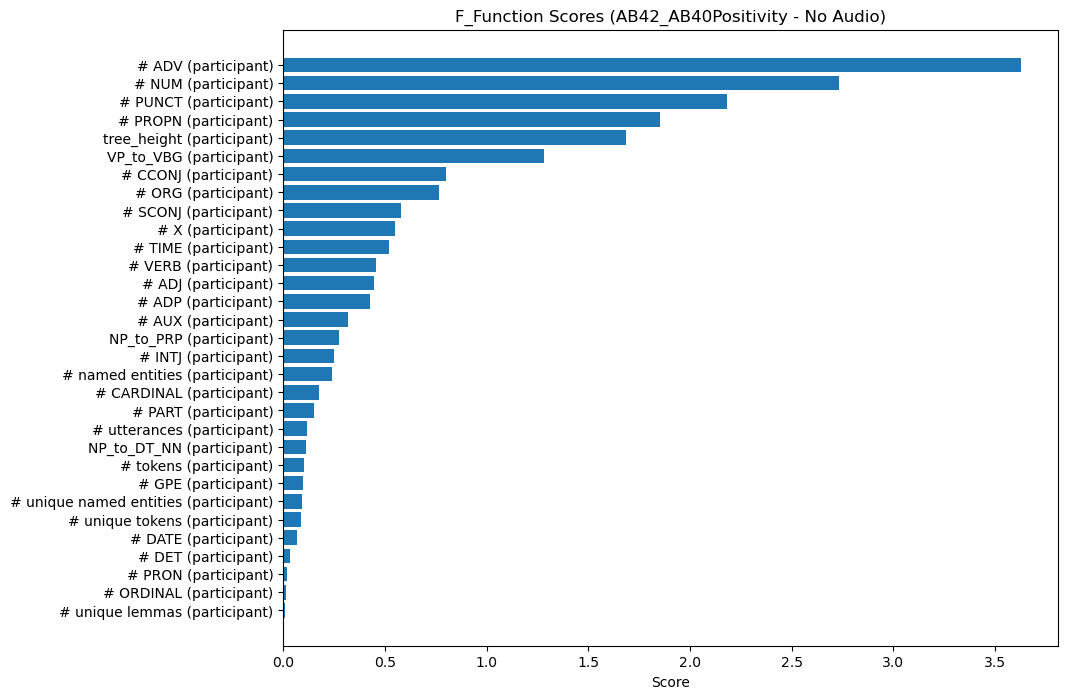

# ADV (participant), # NUM (participant), # PUNCT (participant), # PROPN (participant), tree_height (participant),
VP_to_VBG (participant), # CCONJ (participant), # ORG (participant), # SCONJ (participant), # X (participant),
# TIME (participant), # VERB (participant), # ADJ (participant), # ADP (participant), # AUX (participant),
NP_to_PRP (participant), # INTJ (participant), # named entities (participant), # CARDINAL (participant), # PART (participant),
# utterances (participant), NP_to_DT_NN (participant), # tokens (participant), # GPE (participant), # unique named entities (participant),
# unique tokens (participant), # DATE (participant), # DET (participant), # PRON (participant), # ORDINAL (participant),
# unique lemmas (participant)


In [42]:
MOCA_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('MOCA_impairment', audio=False)
TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('tTau_AB42Positivity', audio=False)
AB42_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('AB42_AB40Positivity', audio=False)

## Mutual Information

In [43]:
def m_info(to_predict, runs=1000, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(32).sort_values()
    for _ in range(runs):
        new_feat_importances = pd.Series(mutual_info_classif(X, y), cols)
        new_feat_importances = new_feat_importances.nlargest(32).sort_values()
        for col in new_feat_importances.index:
            if col not in feat_importances.index:
                feat_importances[col] = 0
            feat_importances[col] += new_feat_importances[col]
    feat_importances = feat_importances / runs
    feat_importances = feat_importances.nlargest(32).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print_feats(list(feat_importances.index)[::-1])
    return list(feat_importances.index[::-1])

### Full Data

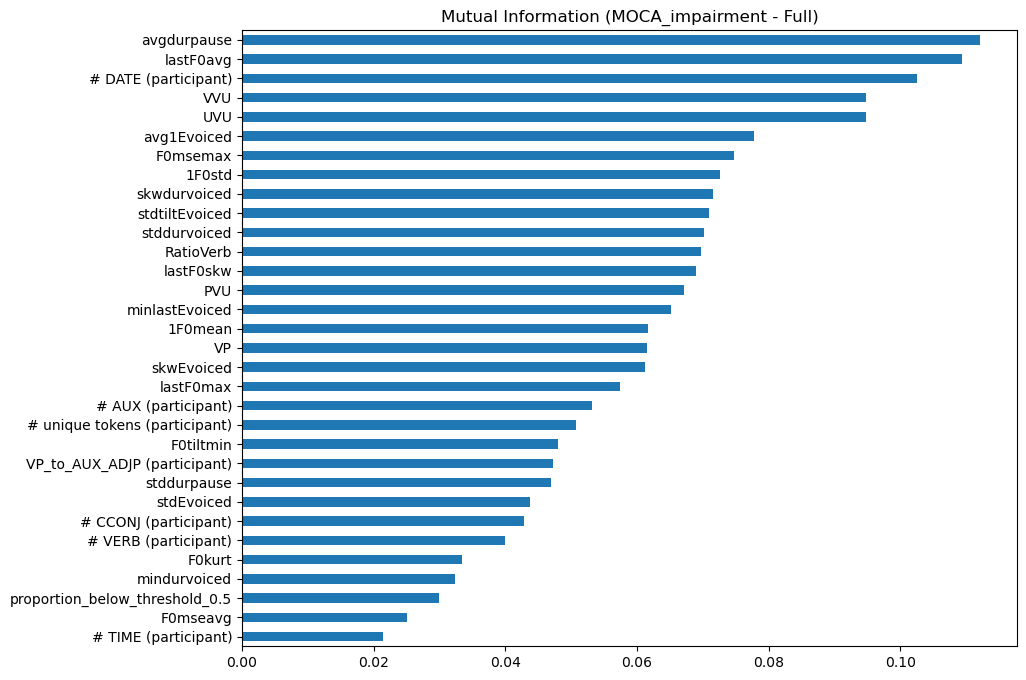

avgdurpause, lastF0avg, # DATE (participant), VVU, UVU,
avg1Evoiced, F0msemax, 1F0std, skwdurvoiced, stdtiltEvoiced,
stddurvoiced, RatioVerb, lastF0skw, PVU, minlastEvoiced,
1F0mean, VP, skwEvoiced, lastF0max, # AUX (participant),
# unique tokens (participant), F0tiltmin, VP_to_AUX_ADJP (participant), stddurpause, stdEvoiced,
# CCONJ (participant), # VERB (participant), F0kurt, mindurvoiced, proportion_below_threshold_0.5,
F0mseavg, # TIME (participant)


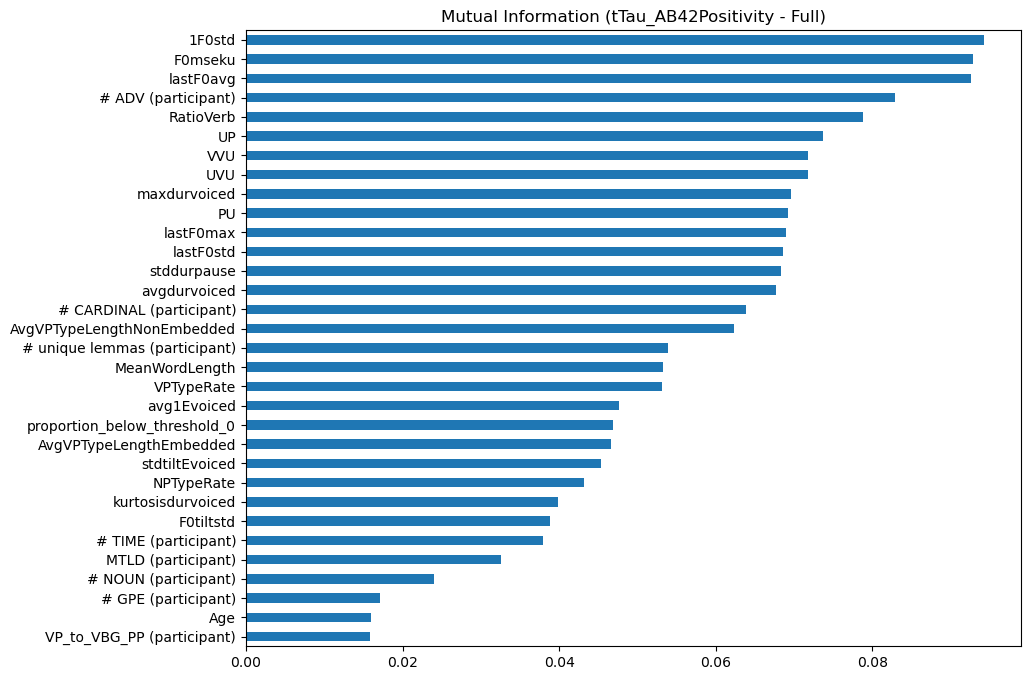

1F0std, F0mseku, lastF0avg, # ADV (participant), RatioVerb,
UP, VVU, UVU, maxdurvoiced, PU,
lastF0max, lastF0std, stddurpause, avgdurvoiced, # CARDINAL (participant),
AvgVPTypeLengthNonEmbedded, # unique lemmas (participant), MeanWordLength, VPTypeRate, avg1Evoiced,
proportion_below_threshold_0, AvgVPTypeLengthEmbedded, stdtiltEvoiced, NPTypeRate, kurtosisdurvoiced,
F0tiltstd, # TIME (participant), MTLD (participant), # NOUN (participant), # GPE (participant),
Age, VP_to_VBG_PP (participant)


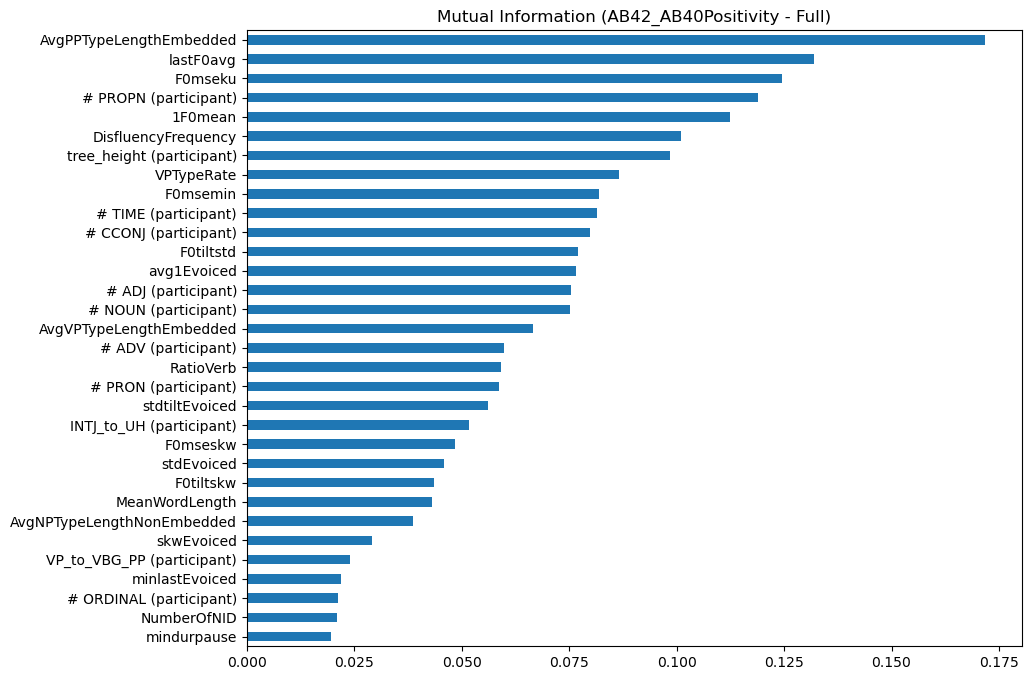

AvgPPTypeLengthEmbedded, lastF0avg, F0mseku, # PROPN (participant), 1F0mean,
DisfluencyFrequency, tree_height (participant), VPTypeRate, F0msemin, # TIME (participant),
# CCONJ (participant), F0tiltstd, avg1Evoiced, # ADJ (participant), # NOUN (participant),
AvgVPTypeLengthEmbedded, # ADV (participant), RatioVerb, # PRON (participant), stdtiltEvoiced,
INTJ_to_UH (participant), F0mseskw, stdEvoiced, F0tiltskw, MeanWordLength,
AvgNPTypeLengthNonEmbedded, skwEvoiced, VP_to_VBG_PP (participant), minlastEvoiced, # ORDINAL (participant),
NumberOfNID, mindurpause


In [44]:
MOCA_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('MOCA_impairment')
TTAU_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('tTau_AB42Positivity')
AB42_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('AB42_AB40Positivity')

### No Audio

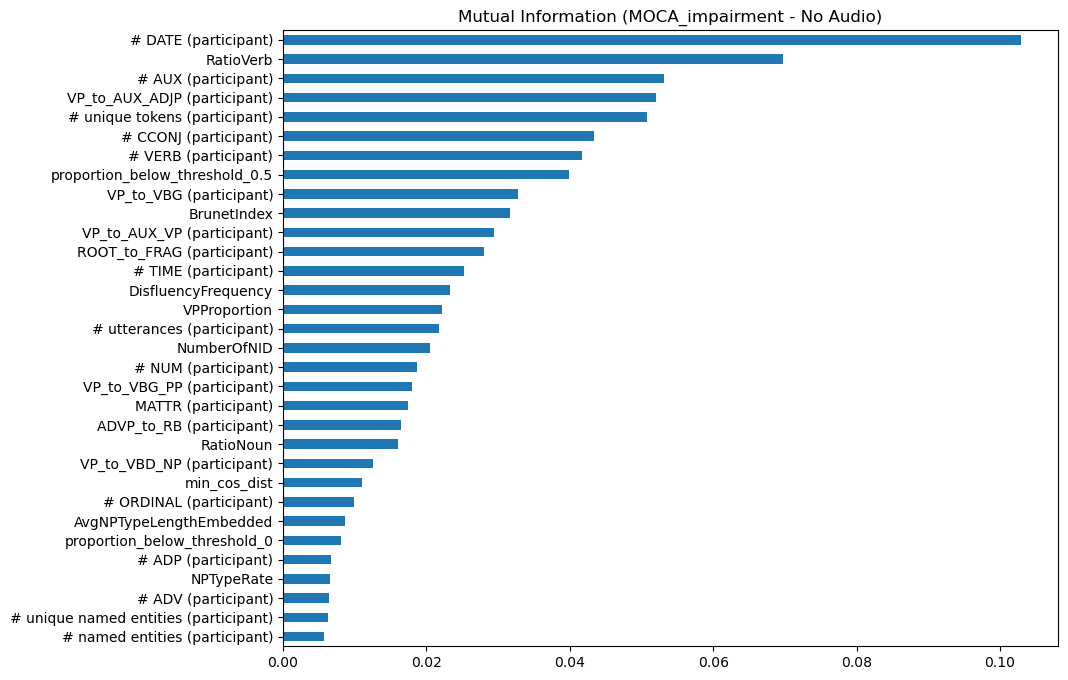

# DATE (participant), RatioVerb, # AUX (participant), VP_to_AUX_ADJP (participant), # unique tokens (participant),
# CCONJ (participant), # VERB (participant), proportion_below_threshold_0.5, VP_to_VBG (participant), BrunetIndex,
VP_to_AUX_VP (participant), ROOT_to_FRAG (participant), # TIME (participant), DisfluencyFrequency, VPProportion,
# utterances (participant), NumberOfNID, # NUM (participant), VP_to_VBG_PP (participant), MATTR (participant),
ADVP_to_RB (participant), RatioNoun, VP_to_VBD_NP (participant), min_cos_dist, # ORDINAL (participant),
AvgNPTypeLengthEmbedded, proportion_below_threshold_0, # ADP (participant), NPTypeRate, # ADV (participant),
# unique named entities (participant), # named entities (participant)


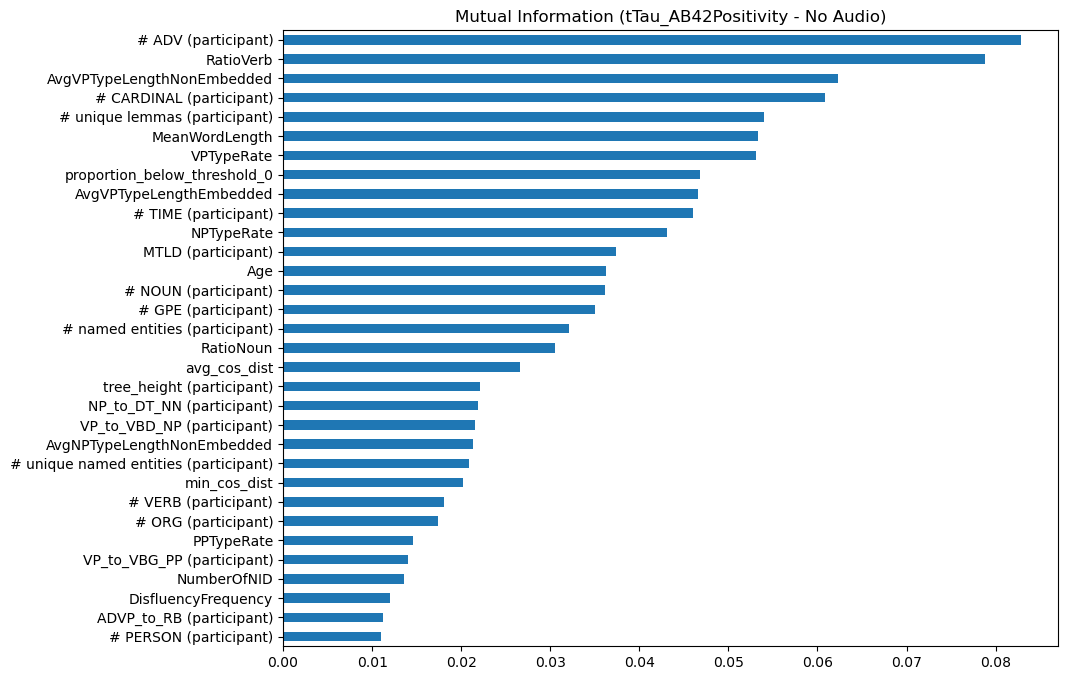

# ADV (participant), RatioVerb, AvgVPTypeLengthNonEmbedded, # CARDINAL (participant), # unique lemmas (participant),
MeanWordLength, VPTypeRate, proportion_below_threshold_0, AvgVPTypeLengthEmbedded, # TIME (participant),
NPTypeRate, MTLD (participant), Age, # NOUN (participant), # GPE (participant),
# named entities (participant), RatioNoun, avg_cos_dist, tree_height (participant), NP_to_DT_NN (participant),
VP_to_VBD_NP (participant), AvgNPTypeLengthNonEmbedded, # unique named entities (participant), min_cos_dist, # VERB (participant),
# ORG (participant), PPTypeRate, VP_to_VBG_PP (participant), NumberOfNID, DisfluencyFrequency,
ADVP_to_RB (participant), # PERSON (participant)


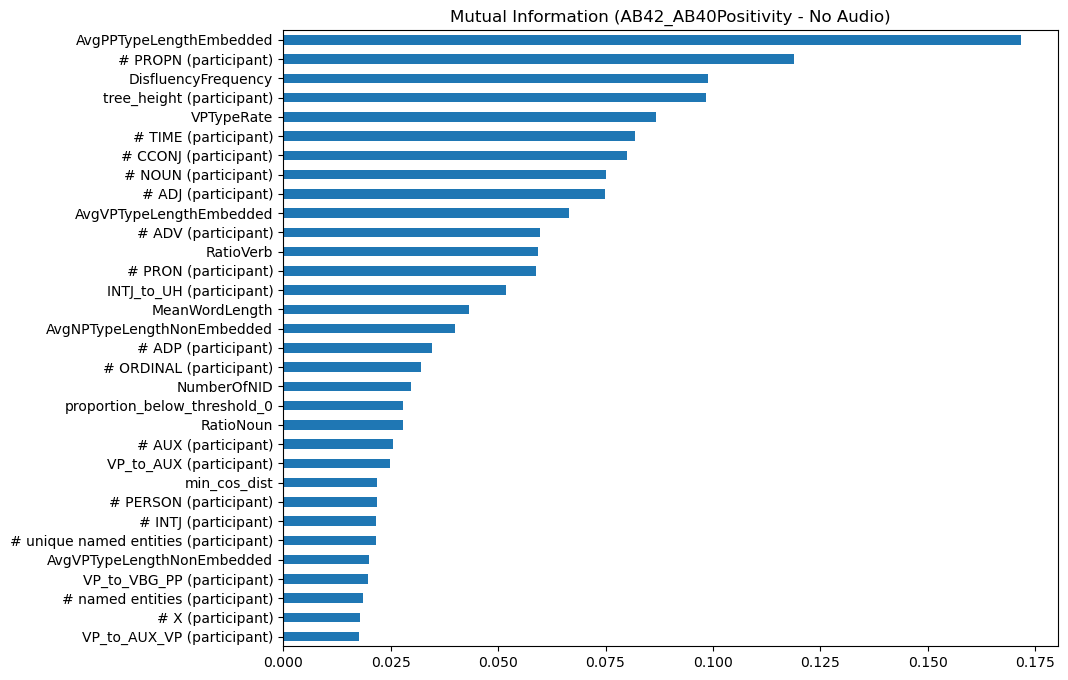

AvgPPTypeLengthEmbedded, # PROPN (participant), DisfluencyFrequency, tree_height (participant), VPTypeRate,
# TIME (participant), # CCONJ (participant), # NOUN (participant), # ADJ (participant), AvgVPTypeLengthEmbedded,
# ADV (participant), RatioVerb, # PRON (participant), INTJ_to_UH (participant), MeanWordLength,
AvgNPTypeLengthNonEmbedded, # ADP (participant), # ORDINAL (participant), NumberOfNID, proportion_below_threshold_0,
RatioNoun, # AUX (participant), VP_to_AUX (participant), min_cos_dist, # PERSON (participant),
# INTJ (participant), # unique named entities (participant), AvgVPTypeLengthNonEmbedded, VP_to_VBG_PP (participant), # named entities (participant),
# X (participant), VP_to_AUX_VP (participant)


In [45]:
MOCA_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('MOCA_impairment', audio=False)
TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('tTau_AB42Positivity', audio=False)
AB42_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('AB42_AB40Positivity', audio=False)

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [46]:
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s, mean_rocs = [], [], []
    stdev_accs, stdev_f1s, stdev_rocs = [], [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s, rocs = [], [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            rocs.append(roc_auc_score(y_test, y_pred))

        mean_accs.append(round(np.mean(accs),4)), mean_f1s.append(round(np.mean(f1s),4)), mean_rocs.append(round(np.mean(rocs),4))
        stdev_accs.append(round(np.std(accs),4)), stdev_f1s.append(round(np.std(f1s),4)), stdev_rocs.append(round(np.std(rocs),4))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s), (mean_rocs, stdev_rocs)


In [47]:
def plot_metrics(accs, f1s, rocs, feats, _steps=STEPS):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(132)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(133)
    plt.title('Average ROC-AUC Score')
    plt.plot(x_axis, rocs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    for idx, step in enumerate(steps):
        print(f'**********   Top {step}   **********')
        print(f'Accuracy:       {accs[0][idx]} +- {accs[1][idx]}')
        print(f'F1 Score:       {f1s[0][idx]} +- {f1s[1][idx]}')
        print(f'ROC-AUC Score:  {rocs[0][idx]} +- {rocs[1][idx]}\n')

## Audio

In [48]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME)

X_moca_audio, y_moca_audio = load_raw_data(PATH, 'MOCA_impairment')
X_ttau_audio, y_ttau_audio = load_raw_data(PATH, 'tTau_AB42Positivity')
X_ab42_audio, y_ab42_audio = load_raw_data(PATH, 'AB42_AB40Positivity')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]



Checking top 4 features


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]



Checking top 8 features


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]



Checking top 16 features


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


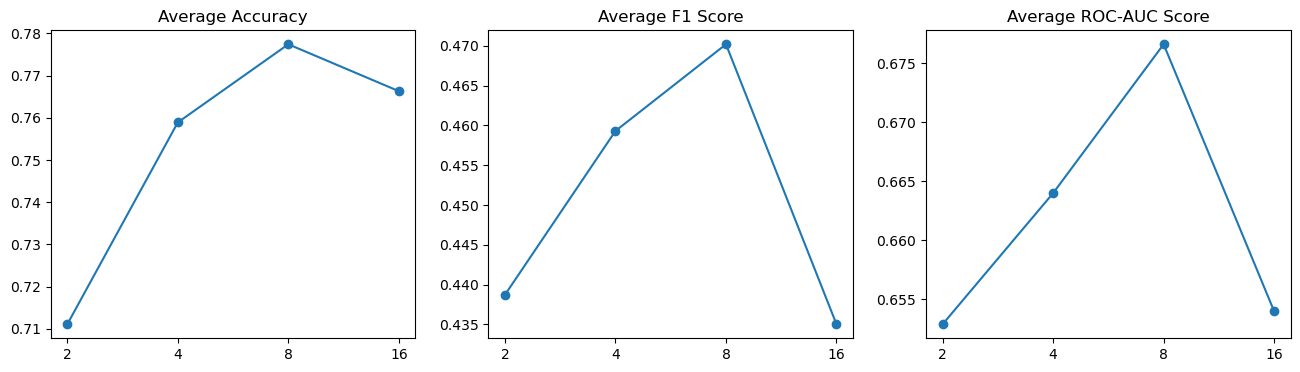

**********   Top 2   **********
Accuracy:       0.7111 +- 0.1064
F1 Score:       0.4387 +- 0.2029
ROC-AUC Score:  0.6529 +- 0.15

**********   Top 4   **********
Accuracy:       0.7589 +- 0.0924
F1 Score:       0.4593 +- 0.1859
ROC-AUC Score:  0.664 +- 0.1224

**********   Top 8   **********
Accuracy:       0.7774 +- 0.0736
F1 Score:       0.4702 +- 0.1878
ROC-AUC Score:  0.6766 +- 0.1257

**********   Top 16   **********
Accuracy:       0.7663 +- 0.0778
F1 Score:       0.435 +- 0.2022
ROC-AUC Score:  0.654 +- 0.1189



In [49]:
moca_ml_audio_feats = MOCA_ML_FULL_COMPUTED_FEATURES[:]
moca_ml_accs, moca_ml_f1s, moca_ml_rocs = check_top_features(X_moca_audio, y_moca_audio, moca_ml_audio_feats)
plot_metrics(moca_ml_accs, moca_ml_f1s, moca_ml_rocs, moca_ml_audio_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]



Checking top 4 features


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]



Checking top 8 features


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]



Checking top 16 features


100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


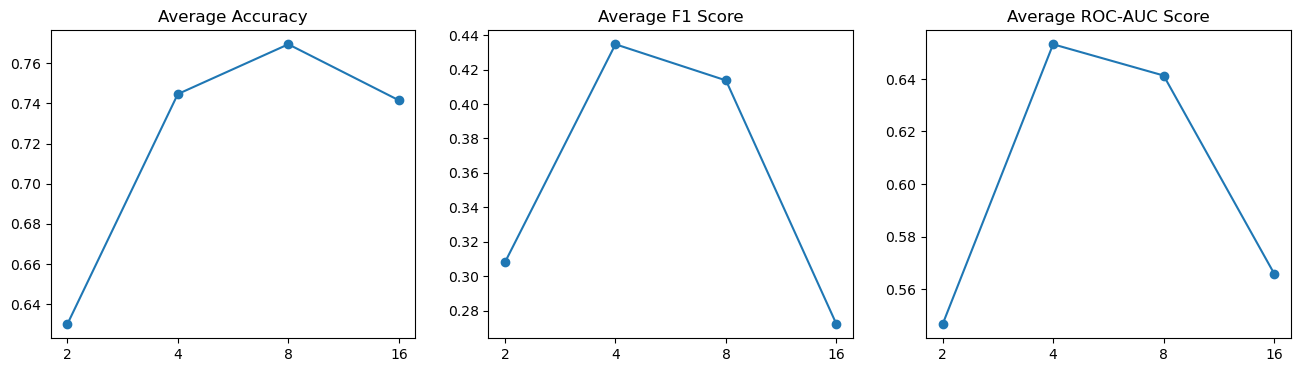

**********   Top 2   **********
Accuracy:       0.63 +- 0.1016
F1 Score:       0.308 +- 0.1688
ROC-AUC Score:  0.5466 +- 0.1284

**********   Top 4   **********
Accuracy:       0.7447 +- 0.0753
F1 Score:       0.4347 +- 0.1704
ROC-AUC Score:  0.6532 +- 0.106

**********   Top 8   **********
Accuracy:       0.7695 +- 0.0728
F1 Score:       0.4137 +- 0.2037
ROC-AUC Score:  0.6413 +- 0.1131

**********   Top 16   **********
Accuracy:       0.7416 +- 0.073
F1 Score:       0.272 +- 0.2243
ROC-AUC Score:  0.5659 +- 0.1175



In [50]:
moca_f_classif_feats_audio = MOCA_F_CLASSIF_FULL_COMPUTED_FEATURES[:]

moca_f_classif_accs_audio, moca_f_classif_f1s_audio, moca_f_classif_rocs_audio = check_top_features(X_moca_audio, y_moca_audio, moca_f_classif_feats_audio)
plot_metrics(moca_f_classif_accs_audio, moca_f_classif_f1s_audio, moca_f_classif_rocs_audio, moca_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]



Checking top 4 features


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]



Checking top 8 features


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]



Checking top 16 features


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


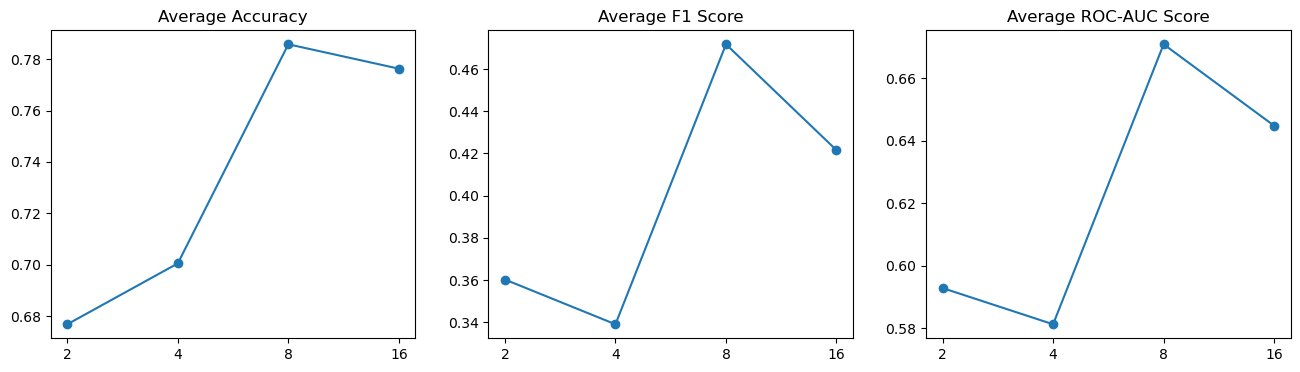

**********   Top 2   **********
Accuracy:       0.6768 +- 0.0918
F1 Score:       0.3602 +- 0.1696
ROC-AUC Score:  0.5928 +- 0.1197

**********   Top 4   **********
Accuracy:       0.7005 +- 0.0736
F1 Score:       0.339 +- 0.1351
ROC-AUC Score:  0.5812 +- 0.0916

**********   Top 8   **********
Accuracy:       0.7858 +- 0.0792
F1 Score:       0.4717 +- 0.1976
ROC-AUC Score:  0.6709 +- 0.1175

**********   Top 16   **********
Accuracy:       0.7763 +- 0.0803
F1 Score:       0.4215 +- 0.2229
ROC-AUC Score:  0.6448 +- 0.1208



In [51]:
moca_mutual_info_feats_audio = MOCA_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

moca_mutual_info_accs_audio, moca_mutual_info_f1s_audio, moca_mutual_info_rocs_audio = check_top_features(X_moca_audio, y_moca_audio, moca_mutual_info_feats_audio)
plot_metrics(moca_mutual_info_accs_audio, moca_mutual_info_f1s_audio, moca_mutual_info_rocs_audio, moca_mutual_info_feats_audio)

### tTau_AB42Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]



Checking top 4 features


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]



Checking top 8 features


100%|██████████| 100/100 [00:25<00:00,  3.97it/s]



Checking top 16 features


100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


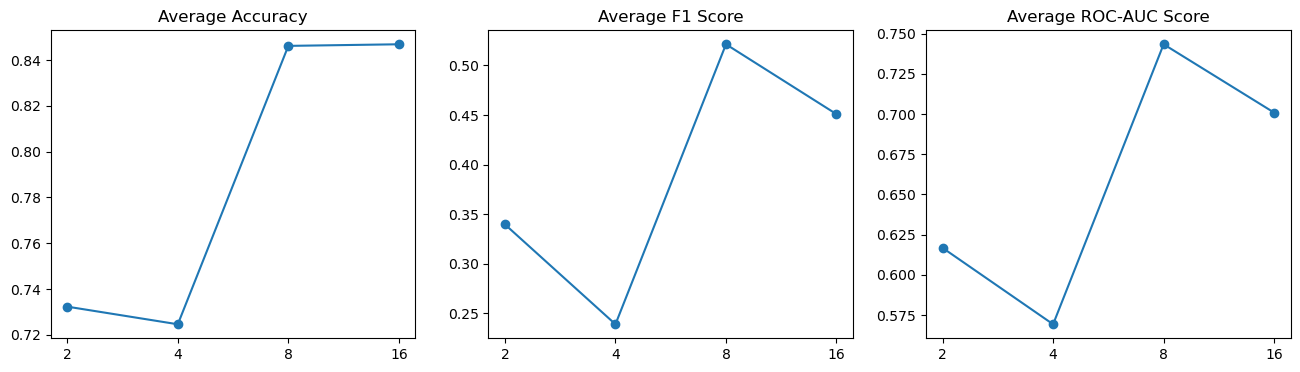

**********   Top 2   **********
Accuracy:       0.7323 +- 0.1164
F1 Score:       0.3397 +- 0.231
ROC-AUC Score:  0.6168 +- 0.1587

**********   Top 4   **********
Accuracy:       0.7246 +- 0.0865
F1 Score:       0.2391 +- 0.2331
ROC-AUC Score:  0.5693 +- 0.16

**********   Top 8   **********
Accuracy:       0.8462 +- 0.0923
F1 Score:       0.5212 +- 0.2898
ROC-AUC Score:  0.7434 +- 0.1742

**********   Top 16   **********
Accuracy:       0.8469 +- 0.086
F1 Score:       0.4508 +- 0.3335
ROC-AUC Score:  0.7009 +- 0.1925



In [52]:
ttau_ml_feats_audio = TTAU_ML_FULL_COMPUTED_FEATURES[:]

ttau_ml_accs_audio, ttau_ml_f1s_audio, ttau_ml_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_ml_feats_audio)
plot_metrics(ttau_ml_accs_audio, ttau_ml_f1s_audio, ttau_ml_rocs_audio, ttau_ml_feats_audio)

In [53]:
TTAU_ML_FULL_COMPUTED_FEATURES[:8]

['UP',
 'maxdurpause',
 'PVU',
 'VP',
 'PU',
 'stddurpause',
 '1F0std',
 'avgdurvoiced']

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]



Checking top 4 features


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]



Checking top 8 features


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


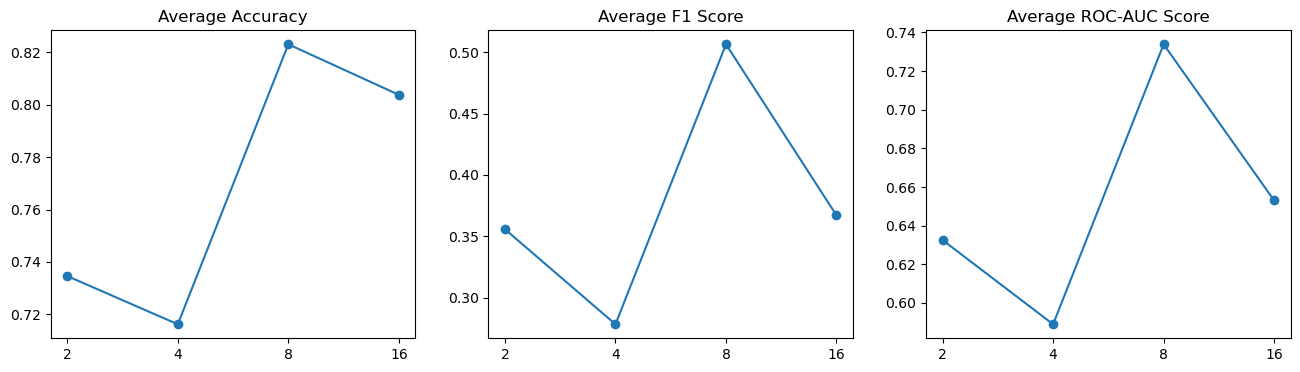

**********   Top 2   **********
Accuracy:       0.7346 +- 0.1174
F1 Score:       0.3557 +- 0.2342
ROC-AUC Score:  0.6325 +- 0.1645

**********   Top 4   **********
Accuracy:       0.7162 +- 0.0946
F1 Score:       0.2782 +- 0.2165
ROC-AUC Score:  0.5889 +- 0.1551

**********   Top 8   **********
Accuracy:       0.8231 +- 0.1063
F1 Score:       0.5065 +- 0.2746
ROC-AUC Score:  0.7339 +- 0.1713

**********   Top 16   **********
Accuracy:       0.8038 +- 0.0981
F1 Score:       0.367 +- 0.3073
ROC-AUC Score:  0.653 +- 0.1904



In [54]:
ttau_f_classif_feats_audio = TTAU_F_CLASSIF_FULL_COMPUTED_FEATURES[:]

ttau_f_classif_accs_audio, ttau_f_classif_f1s_audio, ttau_f_classif_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_ml_feats_audio)
plot_metrics(ttau_f_classif_accs_audio, ttau_f_classif_f1s_audio, ttau_f_classif_rocs_audio, ttau_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 100/100 [00:23<00:00,  4.17it/s]



Checking top 4 features


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]



Checking top 8 features


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]



Checking top 16 features


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


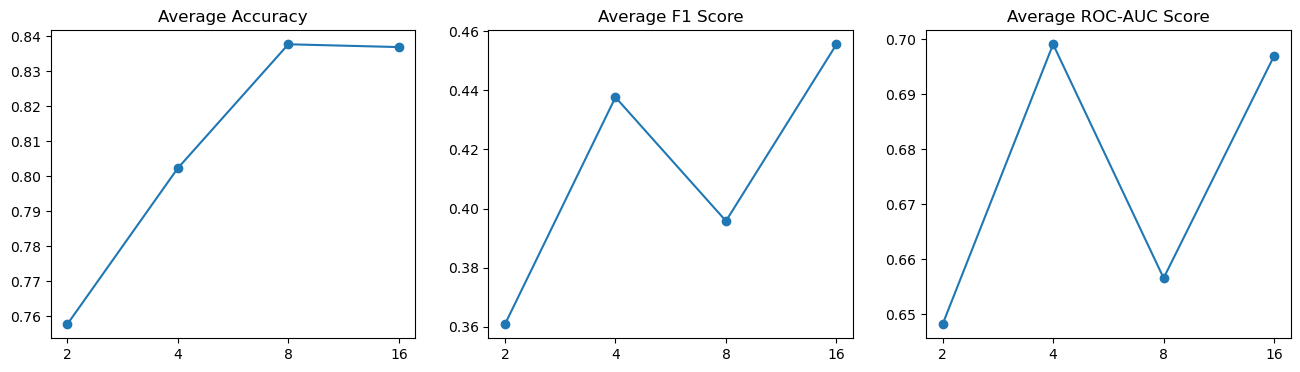

**********   Top 2   **********
Accuracy:       0.7577 +- 0.0993
F1 Score:       0.3609 +- 0.2539
ROC-AUC Score:  0.6482 +- 0.1739

**********   Top 4   **********
Accuracy:       0.8023 +- 0.1056
F1 Score:       0.4376 +- 0.282
ROC-AUC Score:  0.6991 +- 0.1819

**********   Top 8   **********
Accuracy:       0.8377 +- 0.0828
F1 Score:       0.3958 +- 0.3124
ROC-AUC Score:  0.6566 +- 0.1655

**********   Top 16   **********
Accuracy:       0.8369 +- 0.0823
F1 Score:       0.4555 +- 0.2895
ROC-AUC Score:  0.697 +- 0.1652



In [55]:
ttau_mutual_info_feats_audio = TTAU_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

ttau_mutual_info_accs_audio, ttau_mutual_info_f1s_audio, ttau_mutual_info_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_mutual_info_feats_audio)
plot_metrics(ttau_mutual_info_accs_audio, ttau_mutual_info_f1s_audio, ttau_mutual_info_rocs_audio, ttau_mutual_info_feats_audio)

### AB42_AB40Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Checking top 16 features


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


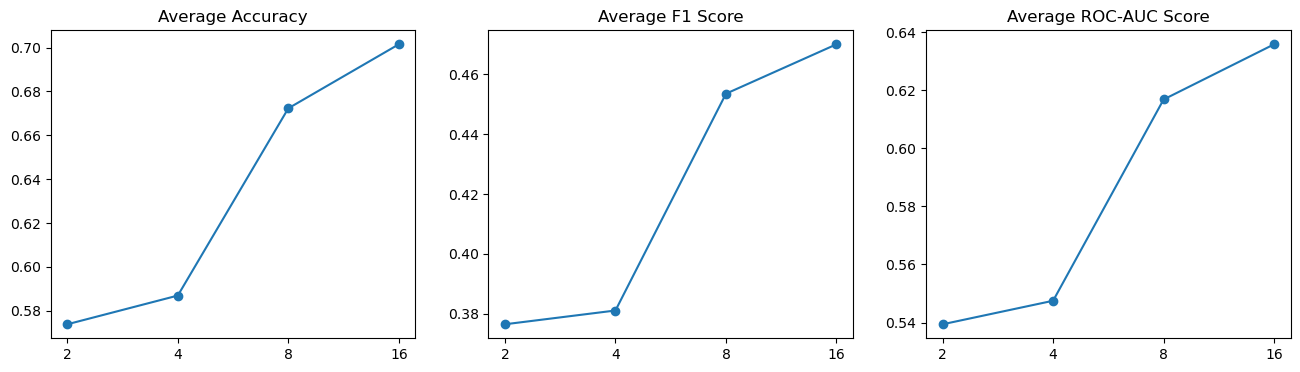

**********   Top 2   **********
Accuracy:       0.5738 +- 0.1261
F1 Score:       0.3765 +- 0.1972
ROC-AUC Score:  0.5394 +- 0.1465

**********   Top 4   **********
Accuracy:       0.5869 +- 0.1075
F1 Score:       0.3811 +- 0.174
ROC-AUC Score:  0.5475 +- 0.118

**********   Top 8   **********
Accuracy:       0.6723 +- 0.1107
F1 Score:       0.4535 +- 0.2056
ROC-AUC Score:  0.6168 +- 0.1279

**********   Top 16   **********
Accuracy:       0.7015 +- 0.1051
F1 Score:       0.47 +- 0.2078
ROC-AUC Score:  0.6358 +- 0.1237



In [56]:
ab42_ml_feats_audio = AB42_ML_FULL_COMPUTED_FEATURES[:]

ab42_ml_accs_audio, ab42_ml_f1s_audio, ab42_ml_rocs_audio = check_top_features(X_ab42_audio, y_ab42_audio, ab42_ml_feats_audio)
plot_metrics(ab42_ml_accs_audio, ab42_ml_f1s_audio, ab42_ml_rocs_audio, ab42_ml_feats_audio)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Checking top 16 features


100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


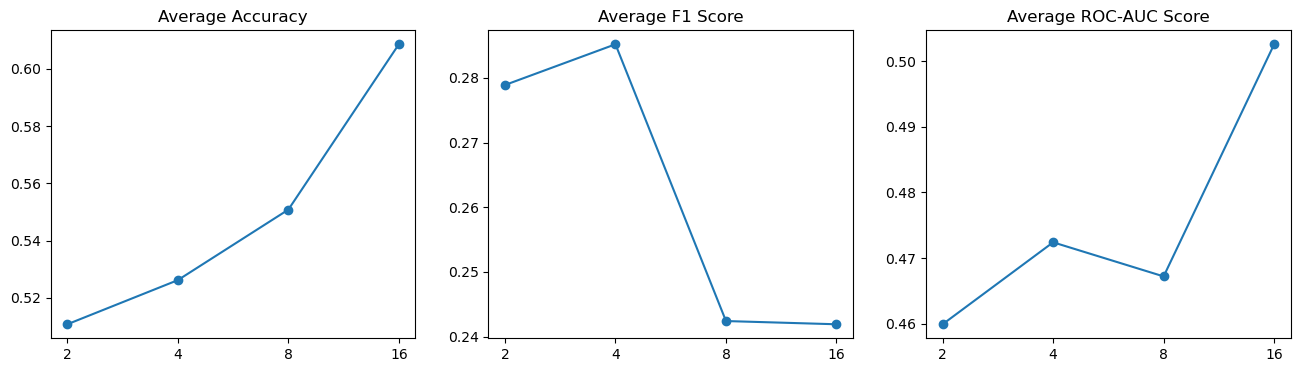

**********   Top 2   **********
Accuracy:       0.5108 +- 0.1276
F1 Score:       0.2789 +- 0.1766
ROC-AUC Score:  0.4599 +- 0.1324

**********   Top 4   **********
Accuracy:       0.5262 +- 0.1258
F1 Score:       0.2852 +- 0.1867
ROC-AUC Score:  0.4724 +- 0.137

**********   Top 8   **********
Accuracy:       0.5508 +- 0.1331
F1 Score:       0.2424 +- 0.21
ROC-AUC Score:  0.4672 +- 0.1427

**********   Top 16   **********
Accuracy:       0.6085 +- 0.1283
F1 Score:       0.2419 +- 0.2287
ROC-AUC Score:  0.5026 +- 0.1339



In [57]:
ab42_f_classif_feats_audio = AB42_F_CLASSIF_FULL_COMPUTED_FEATURES[:]


ab42_f_classif_accs_audio, ab42_f_classif_f1s_audio, ab42_f_classif_rocs_audio = check_top_features(X_ab42_audio, y_ab42_audio, ab42_f_classif_feats_audio)
plot_metrics(ab42_f_classif_accs_audio, ab42_f_classif_f1s_audio, ab42_f_classif_rocs_audio, ab42_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


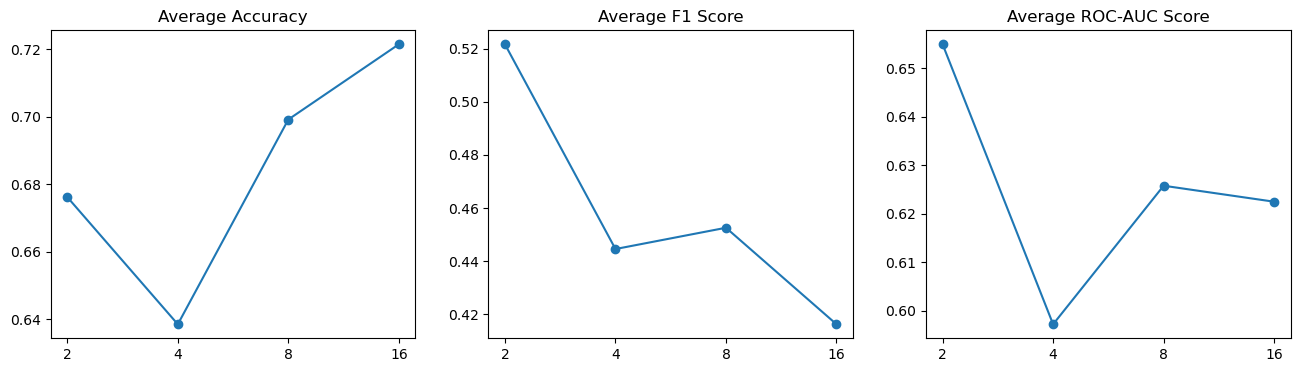

**********   Top 2   **********
Accuracy:       0.6762 +- 0.1178
F1 Score:       0.5216 +- 0.18
ROC-AUC Score:  0.655 +- 0.1349

**********   Top 4   **********
Accuracy:       0.6385 +- 0.1154
F1 Score:       0.4446 +- 0.1635
ROC-AUC Score:  0.5972 +- 0.1162

**********   Top 8   **********
Accuracy:       0.6992 +- 0.1038
F1 Score:       0.4526 +- 0.2045
ROC-AUC Score:  0.6258 +- 0.1238

**********   Top 16   **********
Accuracy:       0.7215 +- 0.0941
F1 Score:       0.4163 +- 0.239
ROC-AUC Score:  0.6225 +- 0.1198



In [58]:
ab42_mutual_info_feats_audio = AB42_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

ab42_mutual_info_accs_audio, ab42_mutual_info_f1s_audio, ab42_mutual_info_rocs_audio = check_top_features(X_ab42_audio, y_ab42_audio, ab42_mutual_info_feats_audio)
plot_metrics(ab42_mutual_info_accs_audio, ab42_mutual_info_f1s_audio, ab42_mutual_info_rocs_audio, ab42_mutual_info_feats_audio)

## No Audio

In [59]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)

X_moca, y_moca = load_raw_data(PATH, 'MOCA_impairment')
X_ttau, y_ttau = load_raw_data(PATH, 'tTau_AB42Positivity')
X_ab42, y_ab42 = load_raw_data(PATH, 'AB42_AB40Positivity')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 100/100 [00:21<00:00,  4.75it/s]



Checking top 4 features


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]



Checking top 8 features


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]



Checking top 16 features


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


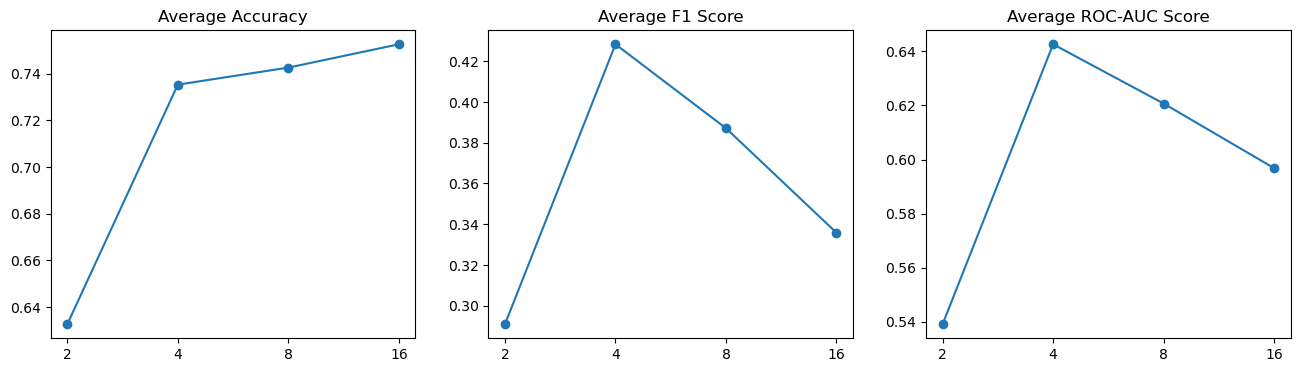

**********   Top 2   **********
Accuracy:       0.6326 +- 0.0968
F1 Score:       0.2909 +- 0.1646
ROC-AUC Score:  0.5391 +- 0.119

**********   Top 4   **********
Accuracy:       0.7353 +- 0.1035
F1 Score:       0.4283 +- 0.1954
ROC-AUC Score:  0.6426 +- 0.135

**********   Top 8   **********
Accuracy:       0.7426 +- 0.0864
F1 Score:       0.3871 +- 0.1989
ROC-AUC Score:  0.6207 +- 0.121

**********   Top 16   **********
Accuracy:       0.7526 +- 0.075
F1 Score:       0.3358 +- 0.2197
ROC-AUC Score:  0.5968 +- 0.1193



In [60]:
moca_ml_feats = MOCA_ML_NO_AUDIO_COMPUTED_FEATURES[:]
moca_ml_accs, moca_ml_f1s, moca_ml_rocs = check_top_features(X_moca, y_moca, moca_ml_feats)
plot_metrics(moca_ml_accs, moca_ml_f1s, moca_ml_rocs, moca_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]



Checking top 4 features


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]



Checking top 8 features


100%|██████████| 100/100 [00:21<00:00,  4.71it/s]



Checking top 16 features


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


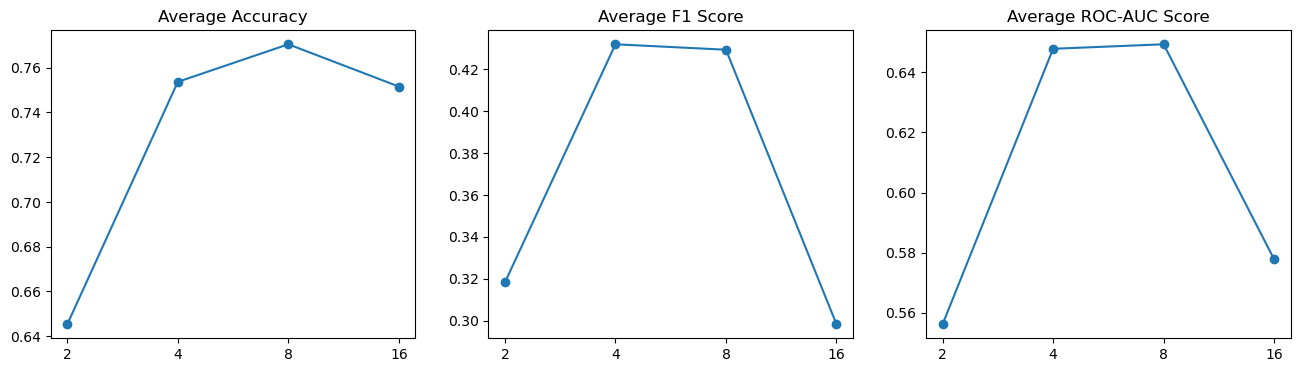

**********   Top 2   **********
Accuracy:       0.6453 +- 0.1011
F1 Score:       0.3183 +- 0.1498
ROC-AUC Score:  0.5562 +- 0.1131

**********   Top 4   **********
Accuracy:       0.7537 +- 0.0835
F1 Score:       0.4319 +- 0.187
ROC-AUC Score:  0.6478 +- 0.1166

**********   Top 8   **********
Accuracy:       0.7705 +- 0.0757
F1 Score:       0.4293 +- 0.1973
ROC-AUC Score:  0.6493 +- 0.1163

**********   Top 16   **********
Accuracy:       0.7516 +- 0.0703
F1 Score:       0.2983 +- 0.2144
ROC-AUC Score:  0.5778 +- 0.1066



In [61]:
moca_f_classif_feats = MOCA_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

moca_f_classif_accs, moca_f_classif_f1s, moca_f_classif_rocs = check_top_features(X_moca, y_moca, moca_f_classif_feats)
plot_metrics(moca_f_classif_accs, moca_f_classif_f1s, moca_f_classif_rocs, moca_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Checking top 4 features


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]



Checking top 8 features


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]



Checking top 16 features


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


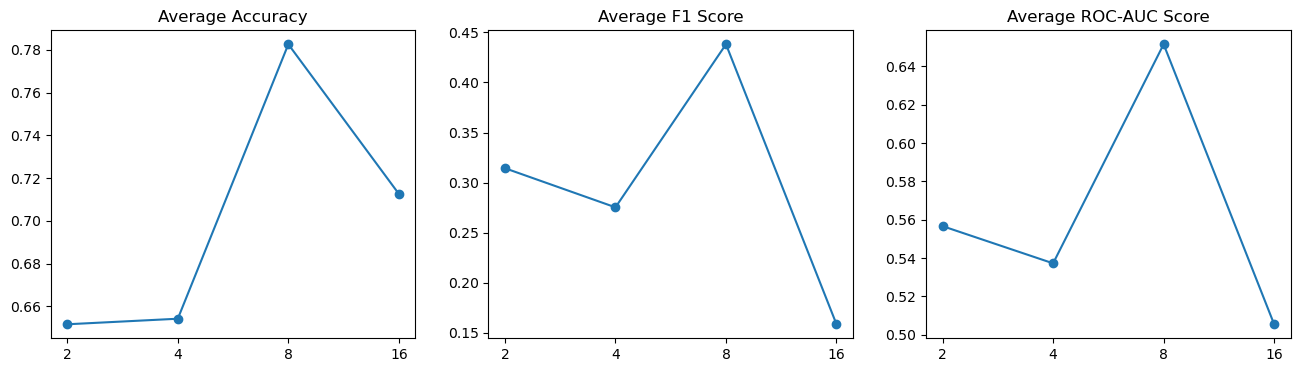

**********   Top 2   **********
Accuracy:       0.6516 +- 0.1167
F1 Score:       0.3143 +- 0.1824
ROC-AUC Score:  0.5566 +- 0.1236

**********   Top 4   **********
Accuracy:       0.6542 +- 0.0991
F1 Score:       0.2752 +- 0.1748
ROC-AUC Score:  0.5372 +- 0.117

**********   Top 8   **********
Accuracy:       0.7826 +- 0.0828
F1 Score:       0.4382 +- 0.201
ROC-AUC Score:  0.6515 +- 0.1168

**********   Top 16   **********
Accuracy:       0.7126 +- 0.0764
F1 Score:       0.1583 +- 0.1834
ROC-AUC Score:  0.5054 +- 0.0945



In [62]:
moca_mutual_info_feats = MOCA_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

moca_mutual_info_accs, moca_mutual_info_f1s, moca_mutual_info_rocs = check_top_features(X_moca, y_moca, moca_mutual_info_feats)
plot_metrics(moca_mutual_info_accs, moca_mutual_info_f1s, moca_mutual_info_rocs, moca_mutual_info_feats)

#### Mixed Sets

In [63]:
moca_top_features = []
a, b = moca_ml_feats[:16], moca_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in moca_top_features:
            moca_top_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in moca_top_features:
            moca_top_features.append(b[idx])

moca_top_accs, moca_top_f1s, moca_top_rocs = check_top_features(X_moca, y_moca, moca_top_features, [2,4,8,16,18])


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]



Checking top 4 features


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]



Checking top 8 features


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]



Checking top 16 features


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]



Checking top 17 features


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


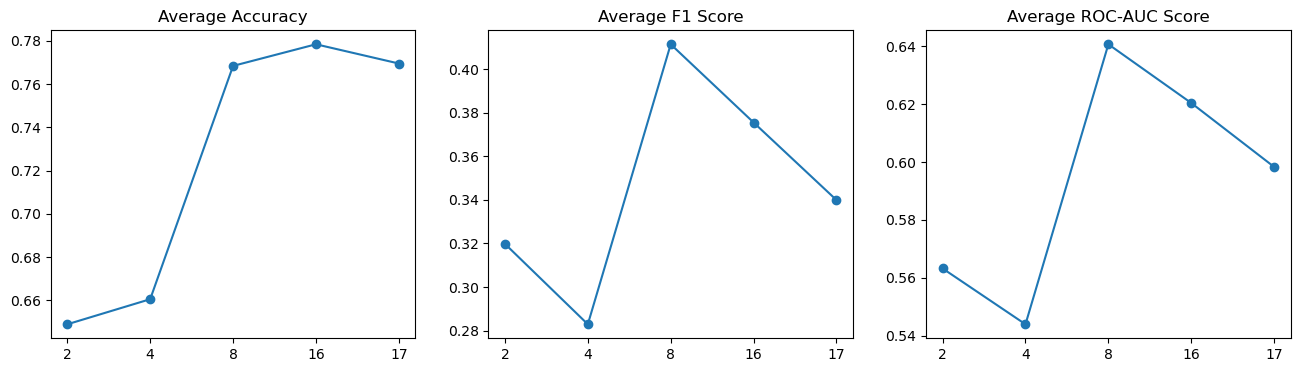

**********   Top 2   **********
Accuracy:       0.6489 +- 0.0996
F1 Score:       0.3198 +- 0.1848
ROC-AUC Score:  0.5632 +- 0.1313

**********   Top 4   **********
Accuracy:       0.6605 +- 0.1
F1 Score:       0.2829 +- 0.1937
ROC-AUC Score:  0.5439 +- 0.1295

**********   Top 8   **********
Accuracy:       0.7684 +- 0.0763
F1 Score:       0.4114 +- 0.2127
ROC-AUC Score:  0.6407 +- 0.1154

**********   Top 16   **********
Accuracy:       0.7784 +- 0.0715
F1 Score:       0.3755 +- 0.2121
ROC-AUC Score:  0.6204 +- 0.108

**********   Top 17   **********
Accuracy:       0.7695 +- 0.0787
F1 Score:       0.3399 +- 0.2171
ROC-AUC Score:  0.5983 +- 0.11



In [64]:
plot_metrics(moca_top_accs, moca_top_f1s, moca_top_rocs, moca_top_features, [2,4,8,16,24])

### MOCA_impairment final results

We have obtained a clear "winner" for this task, in particular the `top 8` from the `statistical approach (mutual information)`.</br>
In particular we have achieved an `accuracy of 0.7913 +- 0.0751` and an `F1 score of 0.4369 +- 0.2055`.

The best features are:
1. `# DATE (participant)`
2. `RatioVerb`
3. `# AUX (participant)`
4. `# unique tokens (participant)`
5. `VP_to_AUX_ADJP (participant)`
6. `# CCONJ (participant)`
7. `# VERB (participant)`
8. `proportion_below_threshold_0.5`

******************************************************************************************************************************************
******************************************************************************************************************************************

### tTau_AB42Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



Checking top 4 features


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]



Checking top 8 features


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



Checking top 16 features


100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


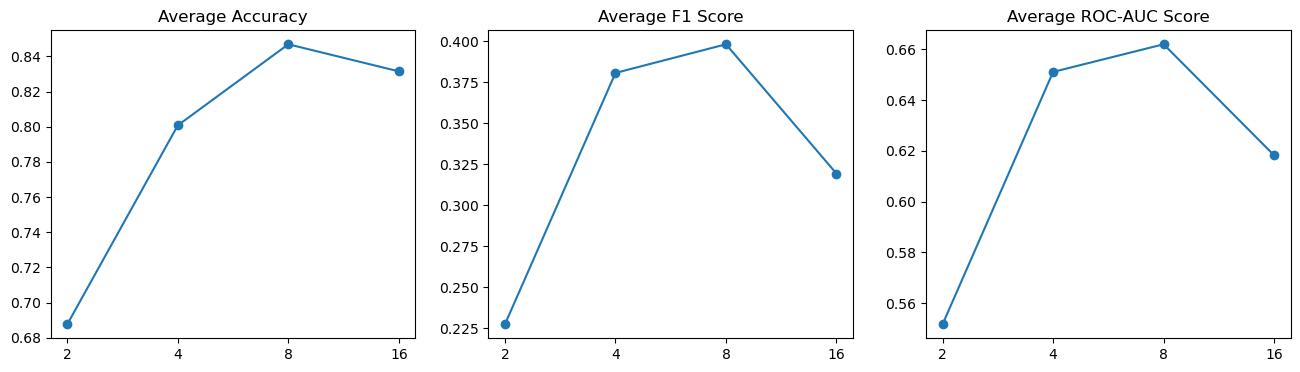

**********   Top 2   **********
Accuracy:       0.6877 +- 0.107
F1 Score:       0.2273 +- 0.2234
ROC-AUC Score:  0.5516 +- 0.1733

**********   Top 4   **********
Accuracy:       0.8008 +- 0.0992
F1 Score:       0.3808 +- 0.2768
ROC-AUC Score:  0.6511 +- 0.1705

**********   Top 8   **********
Accuracy:       0.8469 +- 0.0709
F1 Score:       0.3983 +- 0.302
ROC-AUC Score:  0.662 +- 0.1534

**********   Top 16   **********
Accuracy:       0.8315 +- 0.0782
F1 Score:       0.3193 +- 0.3079
ROC-AUC Score:  0.6182 +- 0.1598



In [65]:
ttau_ml_feats = TTAU_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_ml_accs, ttau_ml_f1s, ttau_ml_rocs = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_metrics(ttau_ml_accs, ttau_ml_f1s, ttau_ml_rocs, ttau_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]



Checking top 4 features


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]



Checking top 8 features


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


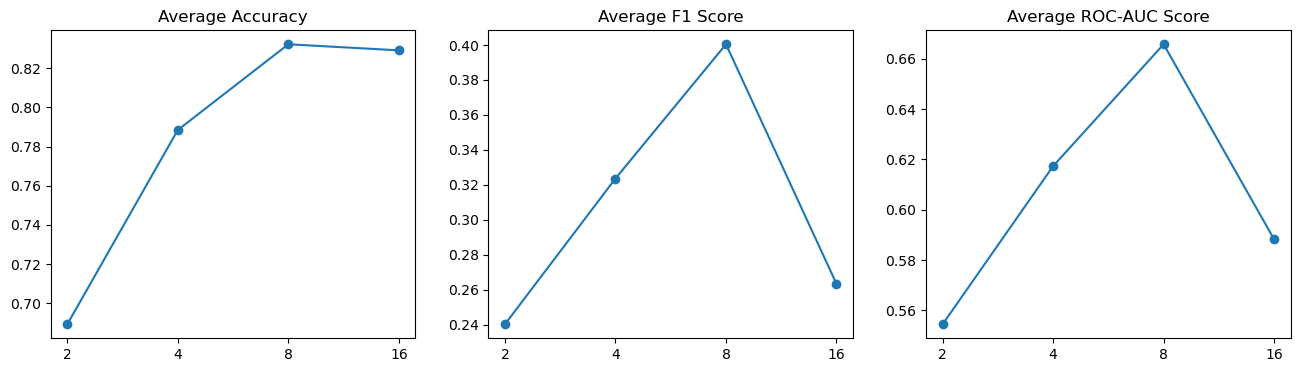

**********   Top 2   **********
Accuracy:       0.6892 +- 0.1087
F1 Score:       0.2402 +- 0.2256
ROC-AUC Score:  0.5545 +- 0.1714

**********   Top 4   **********
Accuracy:       0.7885 +- 0.0987
F1 Score:       0.3236 +- 0.2758
ROC-AUC Score:  0.6173 +- 0.164

**********   Top 8   **********
Accuracy:       0.8323 +- 0.0906
F1 Score:       0.4004 +- 0.3281
ROC-AUC Score:  0.6657 +- 0.1852

**********   Top 16   **********
Accuracy:       0.8292 +- 0.0789
F1 Score:       0.2633 +- 0.3094
ROC-AUC Score:  0.5882 +- 0.1503



In [66]:
ttau_f_classif_feats = TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_rocs = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_metrics(ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_rocs, ttau_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



Checking top 4 features


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]



Checking top 8 features


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


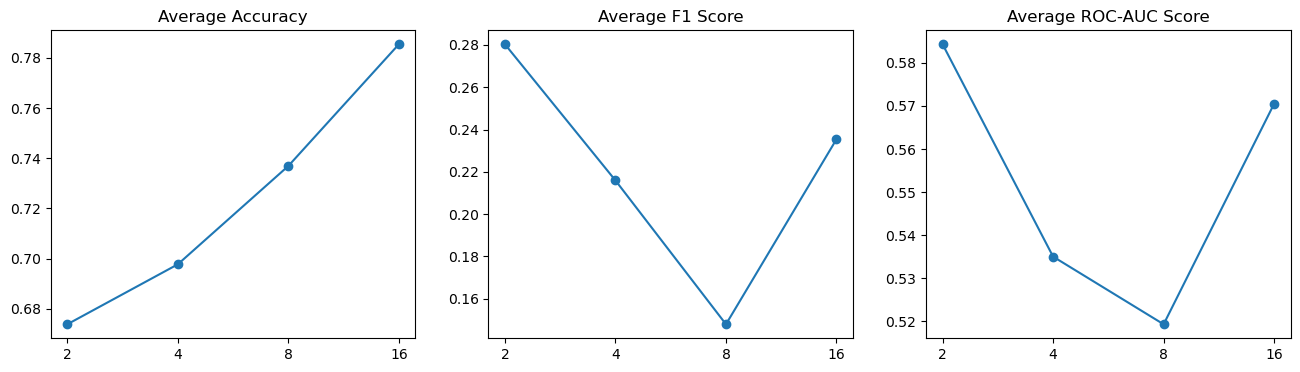

**********   Top 2   **********
Accuracy:       0.6738 +- 0.1142
F1 Score:       0.2803 +- 0.201
ROC-AUC Score:  0.5843 +- 0.1612

**********   Top 4   **********
Accuracy:       0.6977 +- 0.1111
F1 Score:       0.2159 +- 0.24
ROC-AUC Score:  0.535 +- 0.1762

**********   Top 8   **********
Accuracy:       0.7369 +- 0.0878
F1 Score:       0.1479 +- 0.2146
ROC-AUC Score:  0.5193 +- 0.1428

**********   Top 16   **********
Accuracy:       0.7854 +- 0.0845
F1 Score:       0.2354 +- 0.2454
ROC-AUC Score:  0.5705 +- 0.1341



In [67]:
ttau_mutual_info_feats = TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_rocs = check_top_features(X_ttau, y_ttau, ttau_mutual_info_feats)
plot_metrics(ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_rocs, ttau_mutual_info_feats)

In [68]:
ttau_mix_features = []
a, b = ttau_ml_feats[:8], ttau_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ttau_mix_features:
            ttau_mix_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ttau_mix_features:
            ttau_mix_features.append(b[idx])

ttau_mix_accs, ttau_mix_f1s, ttau_mix_rocs = check_top_features(X_ttau, y_ttau, ttau_mix_features, [2,4,8,16])


Checking top 2 features


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]



Checking top 4 features


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]



Checking top 8 features


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]



Checking top 15 features


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


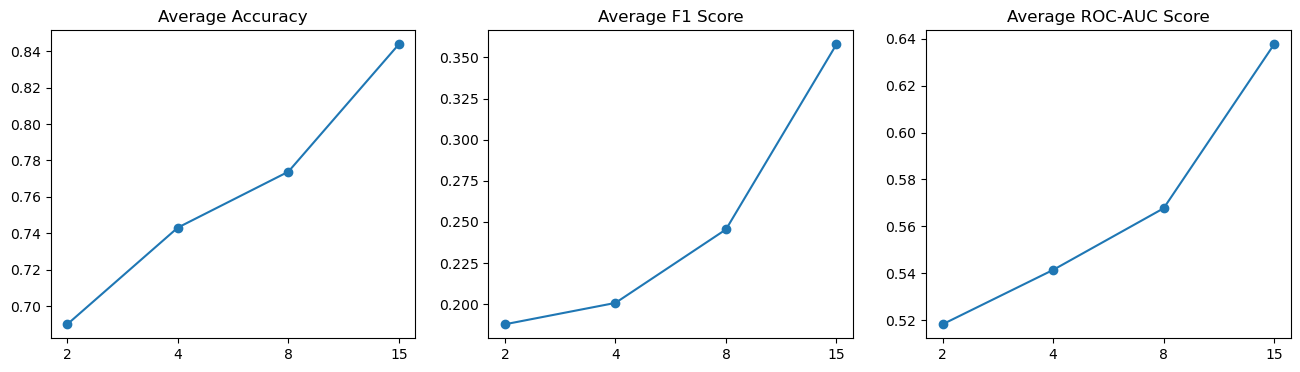

**********   Top 2   **********
Accuracy:       0.69 +- 0.1057
F1 Score:       0.1877 +- 0.2115
ROC-AUC Score:  0.5182 +- 0.1484

**********   Top 4   **********
Accuracy:       0.7431 +- 0.1062
F1 Score:       0.2007 +- 0.2485
ROC-AUC Score:  0.5414 +- 0.1496

**********   Top 8   **********
Accuracy:       0.7738 +- 0.0915
F1 Score:       0.2454 +- 0.2638
ROC-AUC Score:  0.5677 +- 0.1471

**********   Top 15   **********
Accuracy:       0.8438 +- 0.0788
F1 Score:       0.358 +- 0.3307
ROC-AUC Score:  0.6377 +- 0.1685



In [69]:
plot_metrics(ttau_mix_accs, ttau_mix_f1s, ttau_mix_rocs, ttau_mix_features)

### tTau_AB42Positivity final results

For tTau we see that our possible best case scenario is obtained using the `top 8 features` from the `ML approach`.</br>
In particular we have achieved an `accuracy of 0.8208 +- 0.0901` and an `F1 score of 0.3891 +- 0.3009`.

The top features are:
1. `MATTR (participant)`
2. `VP_to_AUX_VP (participant)`
3. `# TIME (participant)`
4. `RatioNoun`
5. `RatioVerb`
6. `tree_height (participant)`
7. `BrunetIndex`
8. `AvgNPTypeLengthNonEmbedded`

******************************************************************************************************************************************
******************************************************************************************************************************************

### AB42_AB40Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


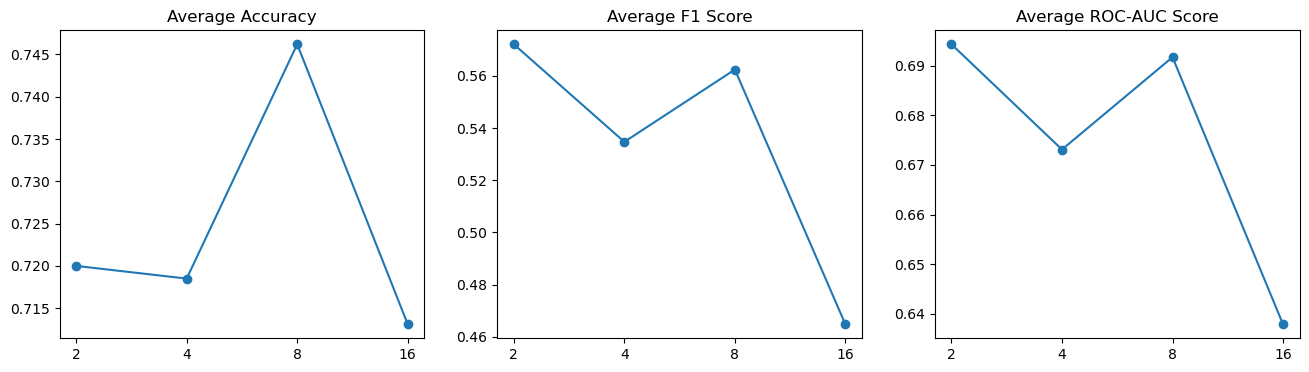

**********   Top 2   **********
Accuracy:       0.72 +- 0.1085
F1 Score:       0.5721 +- 0.1654
ROC-AUC Score:  0.6943 +- 0.1191

**********   Top 4   **********
Accuracy:       0.7185 +- 0.1237
F1 Score:       0.5347 +- 0.2135
ROC-AUC Score:  0.6731 +- 0.1398

**********   Top 8   **********
Accuracy:       0.7462 +- 0.1169
F1 Score:       0.5624 +- 0.2055
ROC-AUC Score:  0.6917 +- 0.1327

**********   Top 16   **********
Accuracy:       0.7131 +- 0.0966
F1 Score:       0.4648 +- 0.2135
ROC-AUC Score:  0.6379 +- 0.1221



In [70]:
ab42_ml_feats = AB42_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ab42_ml_accs, ab42_ml_f1s, ab42_ml_rocs = check_top_features(X_ab42, y_ab42, ab42_ml_feats)
plot_metrics(ab42_ml_accs, ab42_ml_f1s, ab42_ml_rocs, ab42_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


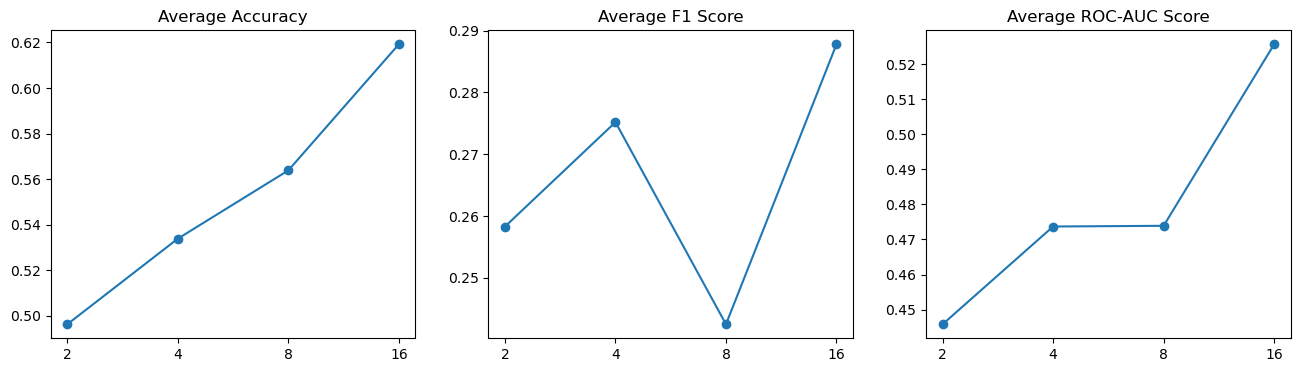

**********   Top 2   **********
Accuracy:       0.4962 +- 0.1223
F1 Score:       0.2583 +- 0.1785
ROC-AUC Score:  0.4458 +- 0.128

**********   Top 4   **********
Accuracy:       0.5338 +- 0.1098
F1 Score:       0.2752 +- 0.1817
ROC-AUC Score:  0.4737 +- 0.121

**********   Top 8   **********
Accuracy:       0.5638 +- 0.135
F1 Score:       0.2425 +- 0.2092
ROC-AUC Score:  0.4739 +- 0.1393

**********   Top 16   **********
Accuracy:       0.6192 +- 0.0963
F1 Score:       0.2878 +- 0.195
ROC-AUC Score:  0.5257 +- 0.1044



In [71]:
ab42_f_classif_feats = AB42_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]


ab42_f_classif_accs, ab42_f_classif_f1s, ab42_f_classif_rocs = check_top_features(X_ab42, y_ab42, ab42_f_classif_feats)
plot_metrics(ab42_f_classif_accs, ab42_f_classif_f1s, ab42_f_classif_rocs, ab42_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]



Checking top 16 features


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


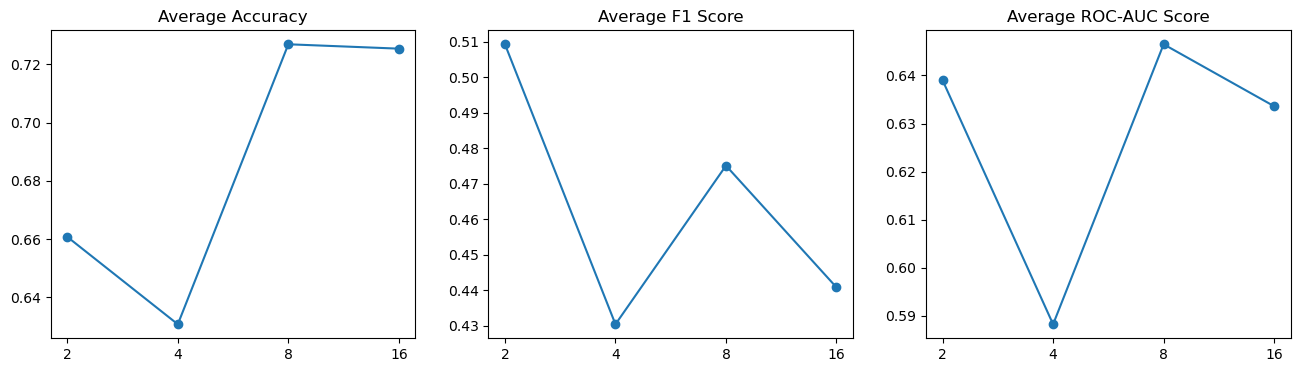

**********   Top 2   **********
Accuracy:       0.6608 +- 0.1197
F1 Score:       0.5093 +- 0.1672
ROC-AUC Score:  0.639 +- 0.1289

**********   Top 4   **********
Accuracy:       0.6308 +- 0.1151
F1 Score:       0.4304 +- 0.1804
ROC-AUC Score:  0.5882 +- 0.1278

**********   Top 8   **********
Accuracy:       0.7269 +- 0.1111
F1 Score:       0.4751 +- 0.234
ROC-AUC Score:  0.6465 +- 0.1328

**********   Top 16   **********
Accuracy:       0.7254 +- 0.0937
F1 Score:       0.4408 +- 0.2347
ROC-AUC Score:  0.6336 +- 0.1223



In [72]:
ab42_mutual_info_feats = AB42_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ab42_mutual_info_accs, ab42_mutual_info_f1s, ab42_mutual_info_rocs = check_top_features(X_ab42, y_ab42, ab42_mutual_info_feats)
plot_metrics(ab42_mutual_info_accs, ab42_mutual_info_f1s, ab42_mutual_info_rocs, ab42_mutual_info_feats)

#### Mixed Sets

In [73]:
ab42_mixed_features = []
a, b = ab42_ml_feats[:8], ab42_mutual_info_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(b[idx])

In [74]:
ab42_top_accs, ab42_top_f1s, ab42_top_rocs = check_top_features(X_ab42, y_ab42, ab42_mixed_features)


Checking top 2 features


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Checking top 4 features


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]



Checking top 8 features


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]



Checking top 13 features


100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


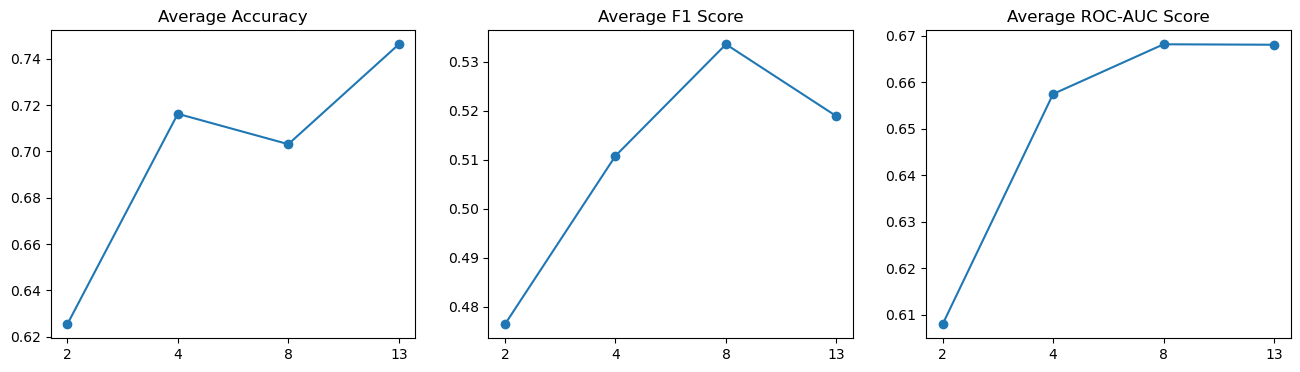

**********   Top 2   **********
Accuracy:       0.6254 +- 0.12
F1 Score:       0.4764 +- 0.1609
ROC-AUC Score:  0.6079 +- 0.1265

**********   Top 4   **********
Accuracy:       0.7162 +- 0.1053
F1 Score:       0.5108 +- 0.1888
ROC-AUC Score:  0.6575 +- 0.1221

**********   Top 8   **********
Accuracy:       0.7031 +- 0.1049
F1 Score:       0.5336 +- 0.1771
ROC-AUC Score:  0.6682 +- 0.1212

**********   Top 13   **********
Accuracy:       0.7462 +- 0.1085
F1 Score:       0.5189 +- 0.2154
ROC-AUC Score:  0.6681 +- 0.1294



In [75]:
plot_metrics(ab42_top_accs, ab42_top_f1s, ab42_top_rocs, ab42_mixed_features)

### AB42_AB40Positivity final results

In the end, the `top 8 ML features` achieve the top accuracy and F1 score without any other method even coming close.</br>
In particular we achieved an `accuracy of 0.7555 +- 0.1132` and an `F1 score of 0.5784 +- 0.2051`.

The features are:
1. `# TIME (participant)`
2. `RatioVerb`
3. `VP_to_AUX_VP (participant)`
4. `RatioNoun`
5. `MATTR (participant)`
6. `# NUM (participant)`
7. `# PROPN (participant)`
8. `VPTypeRate`

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [ ]:
def load_exp(selected_feats, target, typ=int, audio=False):
    # Load the entire csv file
    data = pd.read_csv('data/full_corrected_w_age.csv' if audio else 'data/no_audio_corrected_w_age.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [8]:
import seaborn as sns

MOCA_EXP_FEATS = [
    '# DATE (participant)', 'RatioVerb', '# AUX (participant)', '# unique tokens (participant)',
    'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', '# VERB (participant)', 'proportion_below_threshold_0.5'
 ]
TTAU_EXP_FEATS = [
    'MATTR (participant)', 'VP_to_AUX_VP (participant)', '# TIME (participant)', 'RatioNoun',
    'RatioVerb', 'tree_height (participant)', 'BrunetIndex', 'AvgNPTypeLengthNonEmbedded'
]
AB42_EXP_FEATS = [
    '# TIME (participant)', 'RatioVerb', 'VP_to_AUX_VP (participant)', 'RatioNoun',
    'MATTR (participant)', '# NUM (participant)', '# PROPN (participant)', 'VPTypeRate'
]

TARGETS = ['MOCA_impairment', 'tTau_AB42Positivity', 'AB42_AB40Positivity']

In [61]:
TTAU_EXP_FEATS_AUDIO = [
    'PU', 'UP', 'VP', 'PVU', 'maxdurpause',
    'stddurpause', '1F0std', 'avgdurvoiced'
]

## Variable Correlation

In [128]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target) in enumerate(zip([MOCA_EXP_FEATS, TTAU_EXP_FEATS, AB42_EXP_FEATS], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        fixed = corr_df.columns.to_list()
        for _idx in range(len(fixed)):
            if fixed[_idx] == 'AvgVPTypeLengthEmbedded':
                fixed[_idx] = 'AvgVPType\nLengthEmbedded'
            if fixed[_idx] == 'AvgNPTypeLengthNonEmbedded':
                fixed[_idx] = 'AvgNPType\nLengthNon\nEmbedded'
            if fixed[_idx] == 'proportion_below_threshold_0.5':
                fixed[_idx] = 'proportion_below\nthreshold_0.5'
        corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[target if not special else special[idx]]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[target if not special else special[idx]]))
    return series, annots

In [125]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=3, figsize=(12,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    sns.heatmap(series[2], annot=annots[2], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[2]], fmt = '')
    plt.subplots_adjust(wspace=1.4, top=0.92)
    plt.show()

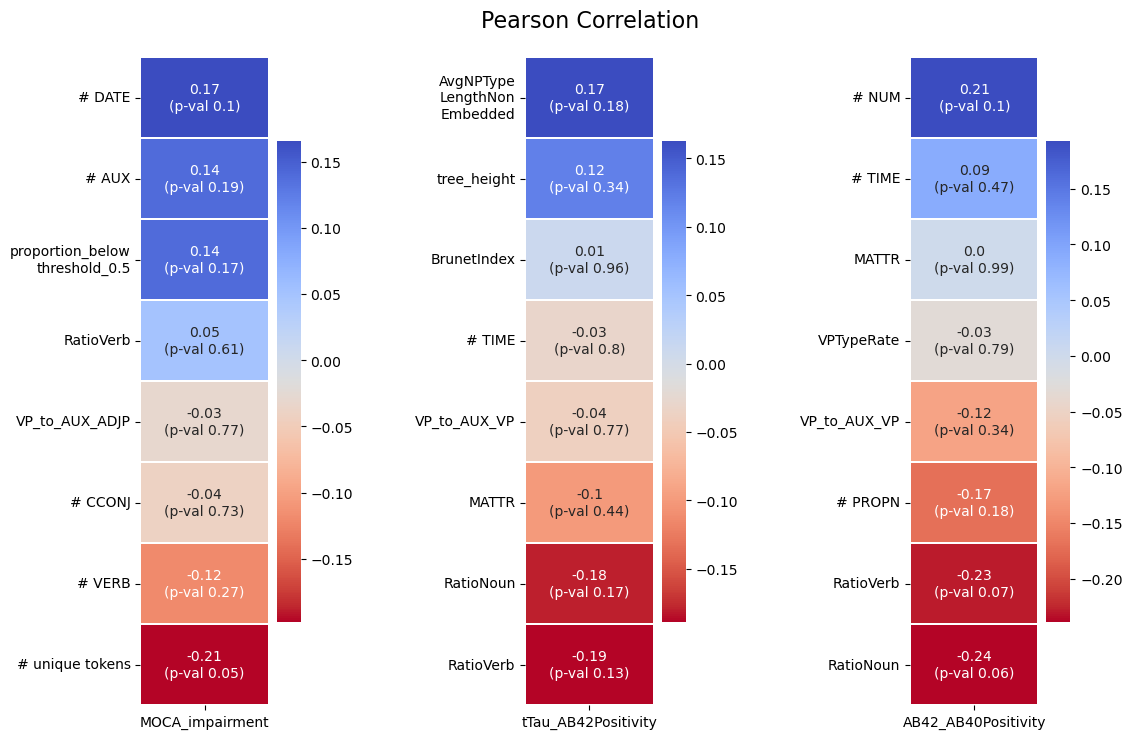

In [129]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

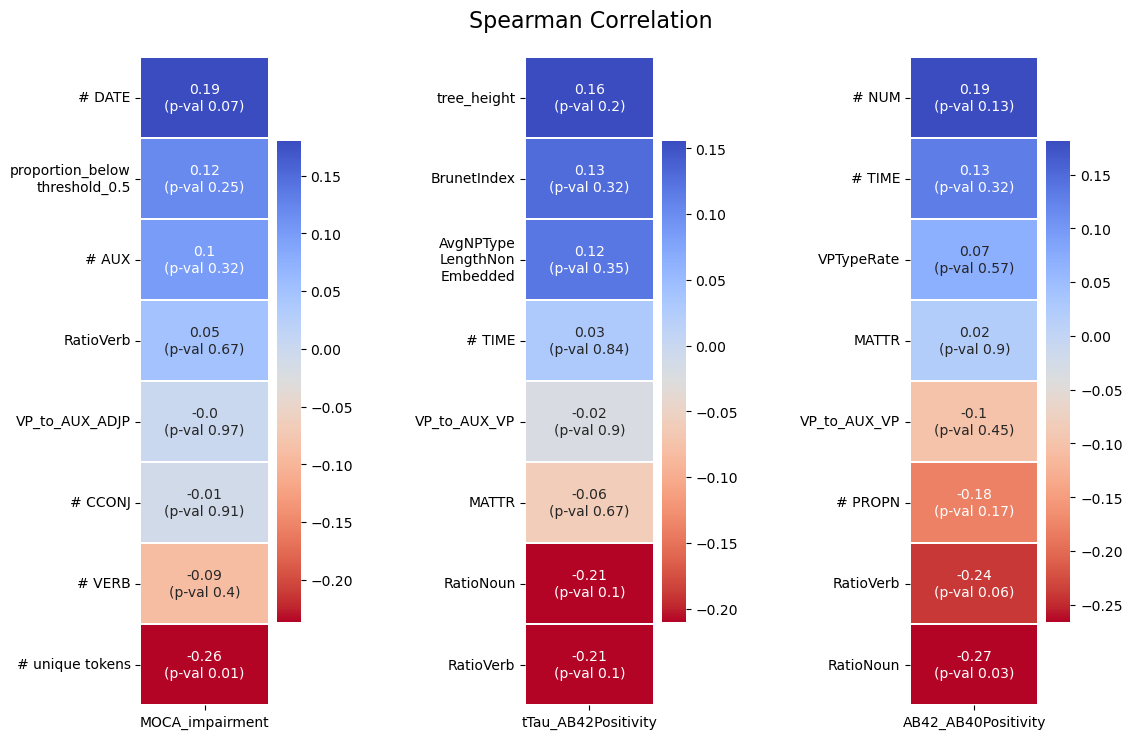

In [130]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

### MOCA
Even taking into consideration both of the correlation functions, only one feature has statistical relevance: `# unique tokens`. Not exactly perfect, but the only meaningful results is also exactly what we do expect: someone healthy should probably generate more unique tokens given more complex/rich language patterns. Thus, the higher `# unique tokens` is, the lower is the probability of observing a dementia patient.

### tTau
Same story as MOCA, the only element that showed some statistical significance (only with Pearson correlation coefficients) is `BrunetIndex`. Once again, this also goes in the direction that we expected because higher BrunetIndex relates to less complex language patterns, so a high BrunetIndex correlates positively with dementia.

### AB42
Here we have 2 features that correlate negatively with Dementia: `RatioVerb` and `RatioNoun`. Also, we see that `MATTR` do not really correlates to anything (at least if we look at the Pearson correlation).

## WRT Clinical Diagnosis

In [72]:
# Filters
def filter_ad(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'MCI'].index)

def filter_mci(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'Prob AD'].index)

In [73]:
# Encodings
def encode_ad_mci(x):
    if x == 'Normal' or x=='Normal-PD':
        return 0
    return 1

def encode_ad(x):
    if x == 'Prob AD':
        return 1
    return 0
        
def encode_mci(x):
    if x == 'MCI':
        return 1
    return 0

### Control vs Prob AD

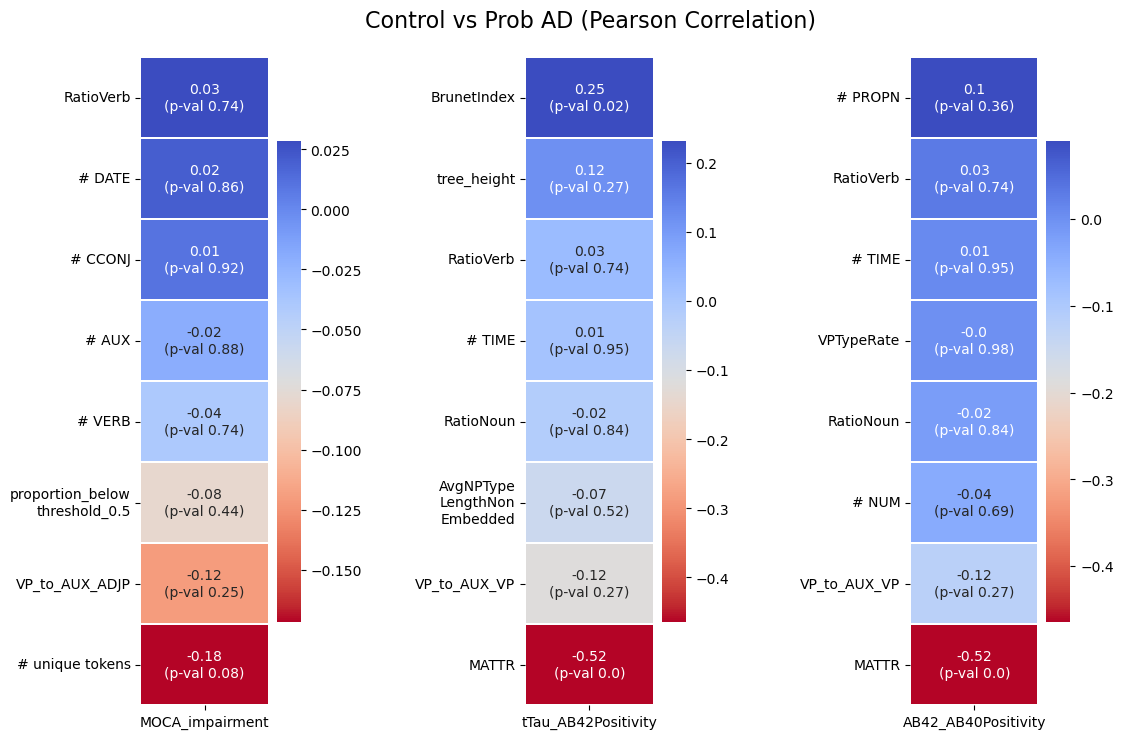

In [131]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Pearson Correlation)")

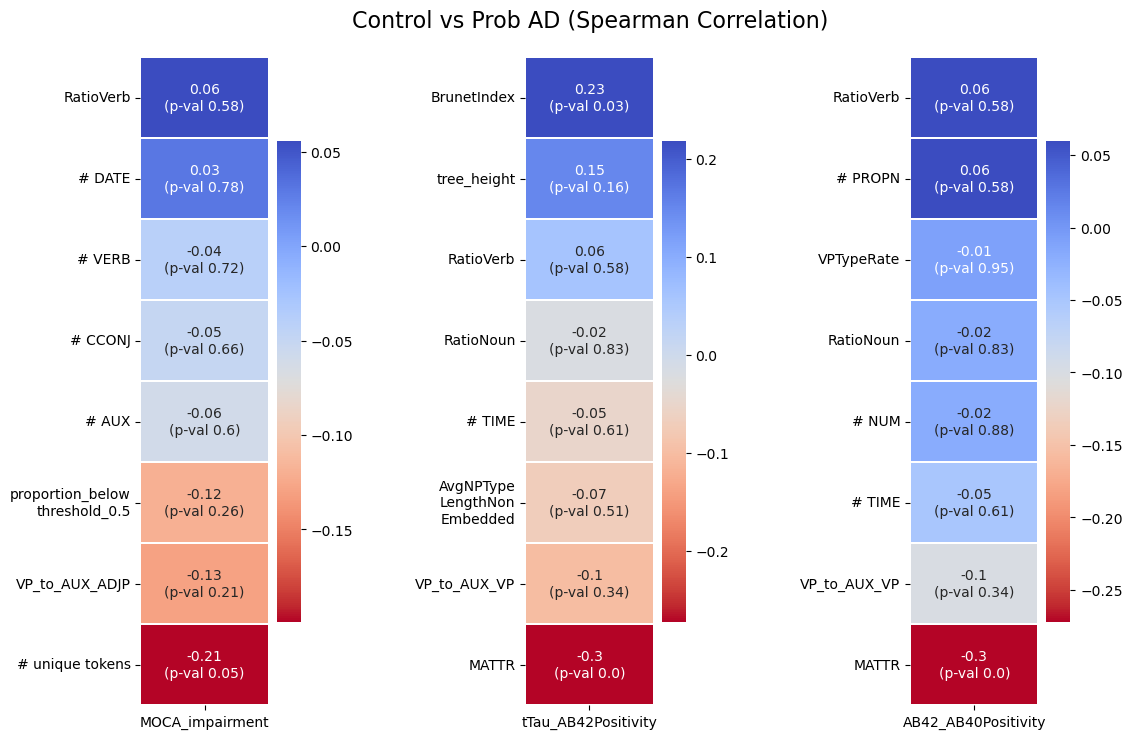

In [132]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Spearman Correlation)")

### MOCA Features
No values with statistical significance.

### tTau Features
Both `MATTR` and `BrunetIndex` show the exact correlation that we may expect (high MATTR = healthy, and high BrunetIndex = dementia).

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI

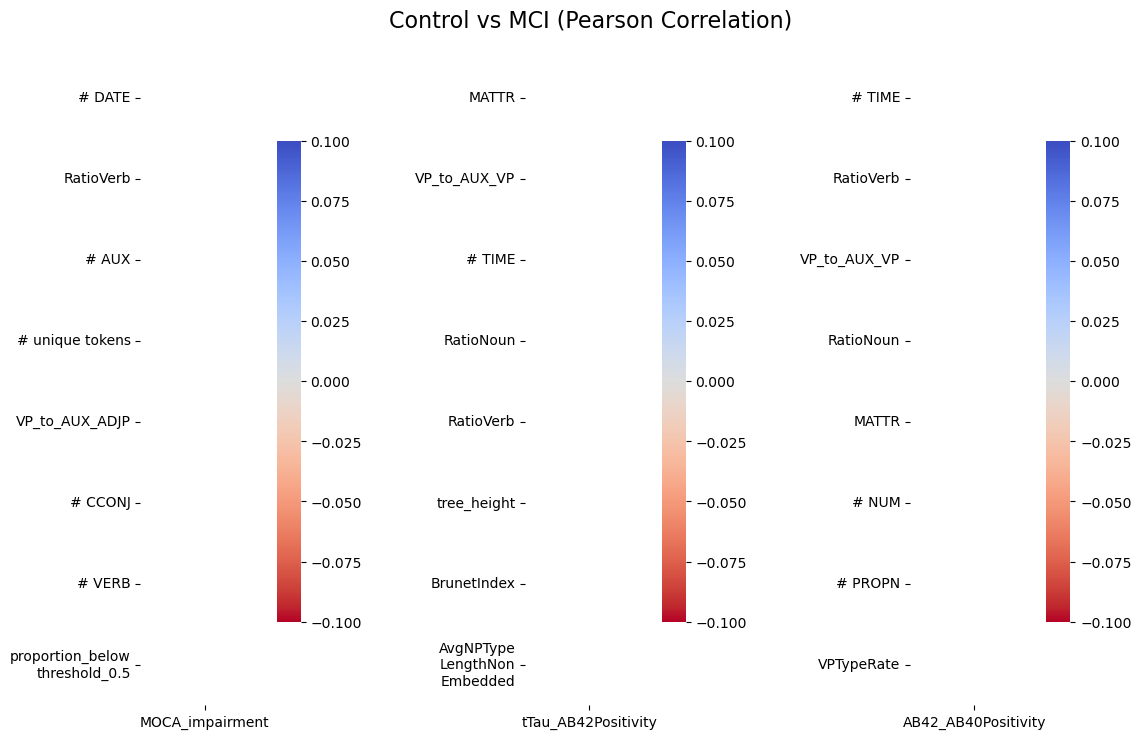

In [133]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_mci, encoding=encode_mci)
plot_correlation(series, annots, "Control vs MCI (Pearson Correlation)")

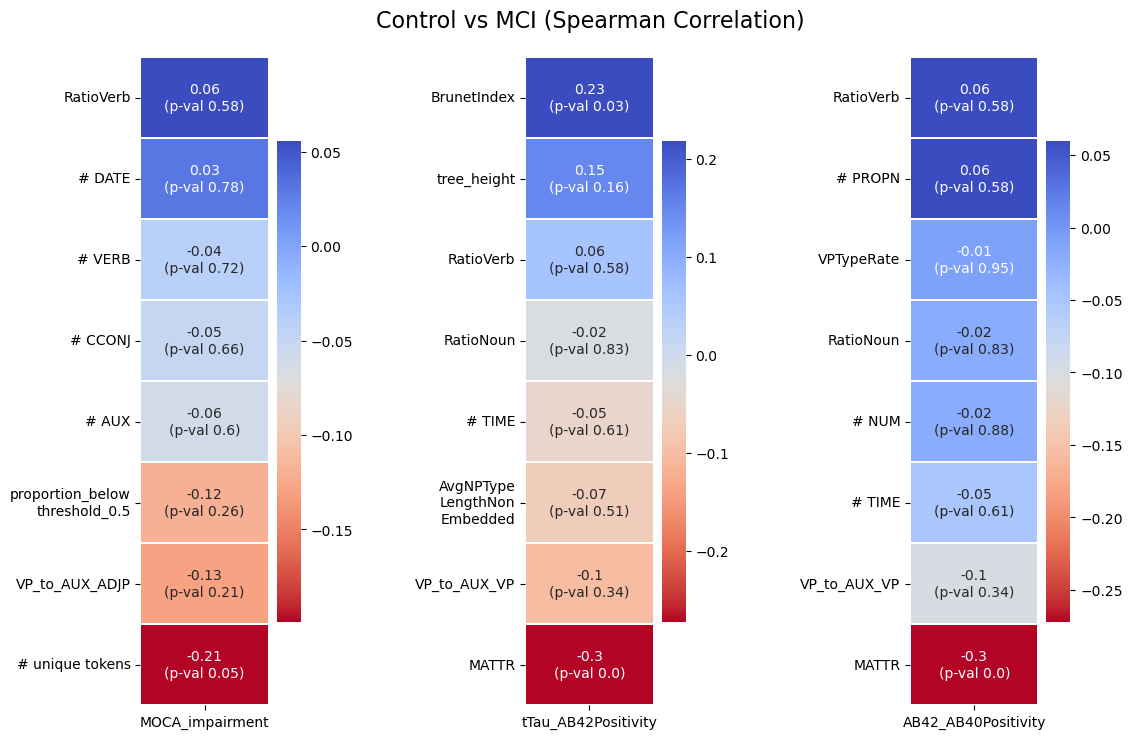

In [134]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI (Spearman Correlation)")

Interestingly, the Pearson correlation refused to produce any values for this experiment. Still unclear if this is a coding problem, or a data problem.

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
Expected correlation for `MATTR`.

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI & Prob AD

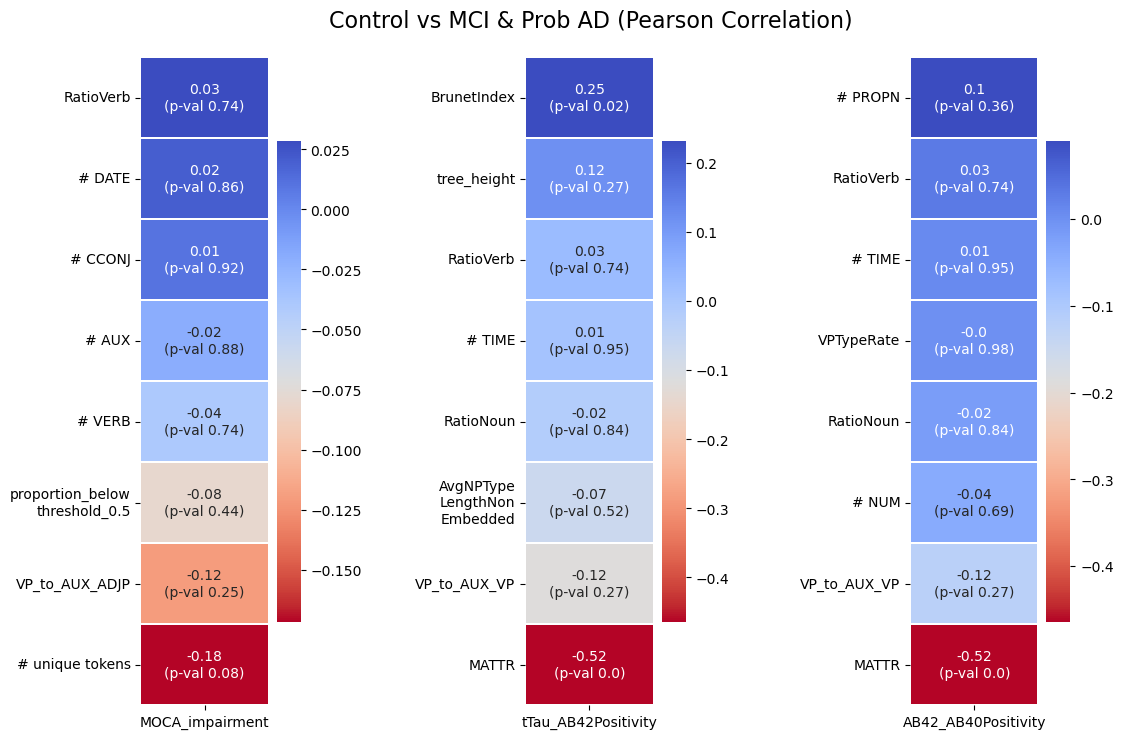

In [135]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Pearson Correlation)")

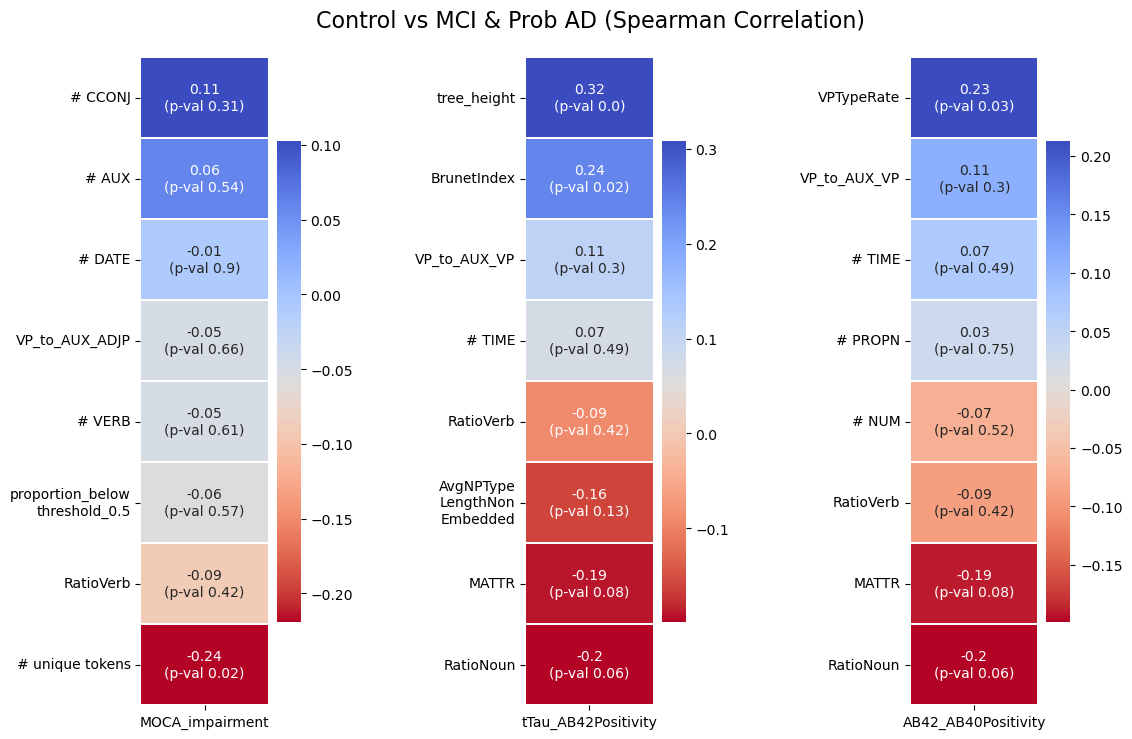

In [136]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, encoding=encode_ad_mci)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Spearman Correlation)")

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
`tree_height` seems to be strongly correlated to dementia parient, and the possible explanation is related to the fact that dementia patient connect a lot of utterances with `AND`, and the tree may have been generated counting all these connected utterances as part of the same sentence, thus generating one enormous tree.

### AB42 Features
No significant values.

## Shap Values

In [62]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [64]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [65]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [66]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [67]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [73]:
def explain(target, features, cv_repetitions, seeds, audio=False):
    df = load_exp(features, target, audio=audio)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [69]:
def plot_shap_vals(X: pd.DataFrame, average_values, label, cv_repetitions):
    cols = []
    for col in list(X.columns):
        if col == 'proportion_below_threshold_0.5':
            col = 'proportion_below\nthreshold_0.5'
        if col == 'AvgNPTypeLengthNonEmbedded':
            col = 'AvgNPTypeLength\nNonEmbedded'
        cols.append(col)
    X.columns = cols
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.xlabel('')
    plt.show()

In [70]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### MOCA_impairment

In [17]:
MOCA_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_moca_exp, moca_class_0, moca_class_1 = explain('MOCA_impairment', MOCA_EXP_FEATS, CV_REPETITIONS, MOCA_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


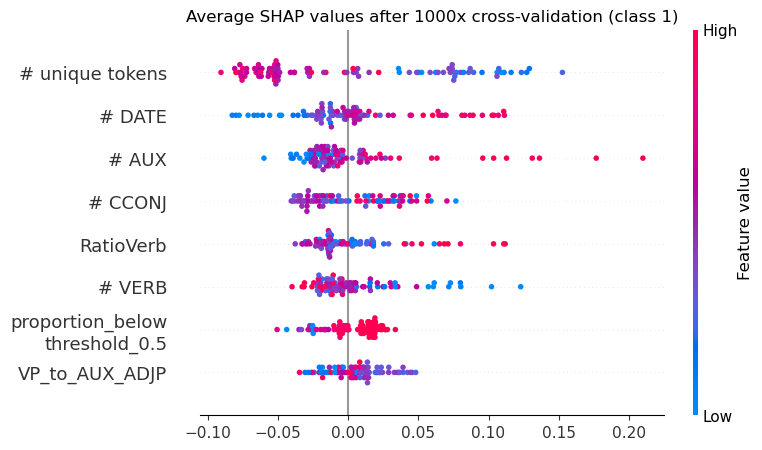

In [18]:
plot_shap_vals(X_moca_exp, moca_class_1[0], 1, CV_REPETITIONS)

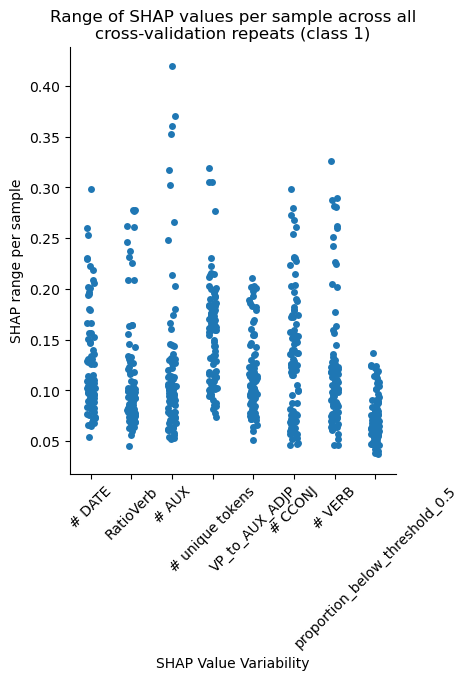

In [101]:
plot_ranges(X_moca_exp, moca_class_1[2], 1)

### tTau_AB42Positivity (no Audio)

In [19]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('tTau_AB42Positivity', TTAU_EXP_FEATS, CV_REPETITIONS, TTAU_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:46<00:00,  1.13it/s]


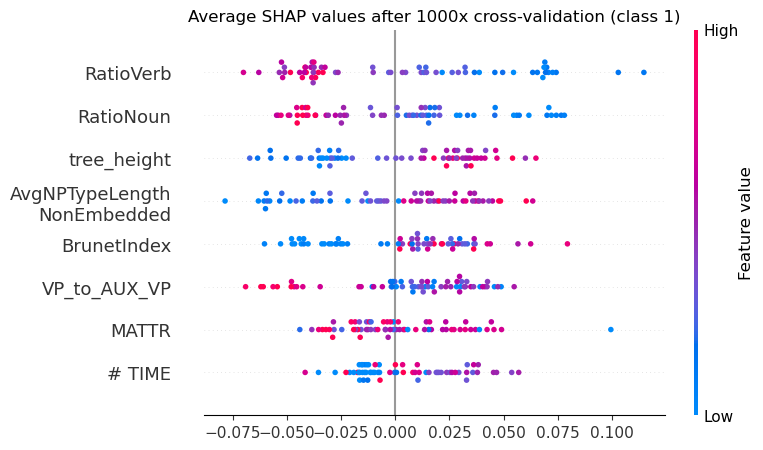

In [20]:
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

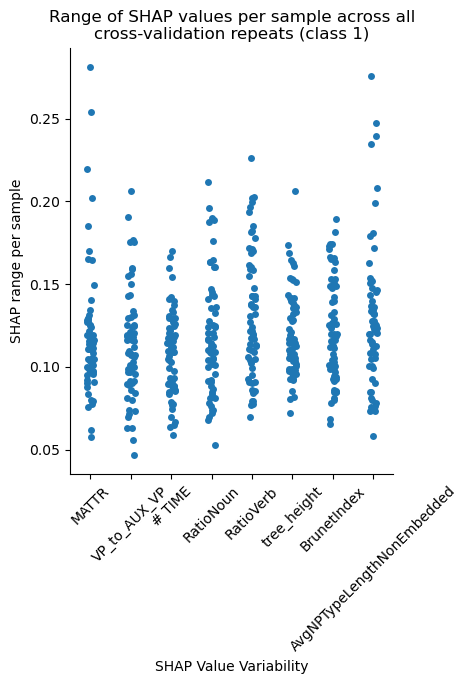

In [103]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### tTau_AB42Positivity (Full)

In [75]:
TTAU_AUDIO_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp_audio, ttau_class_0_audio, ttau_class_1_audio = explain('tTau_AB42Positivity', TTAU_EXP_FEATS_AUDIO, CV_REPETITIONS, TTAU_AUDIO_SEEDS, audio=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:54<00:00,  1.12it/s]


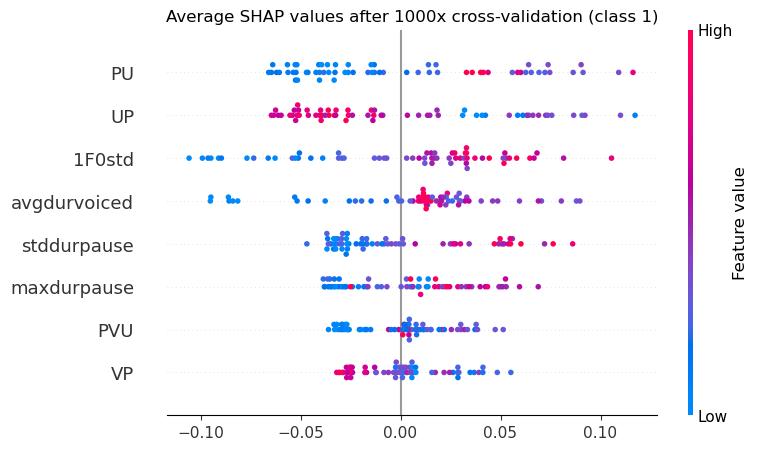

In [76]:
plot_shap_vals(X_ttau_exp_audio, ttau_class_1_audio[0], 1, CV_REPETITIONS)

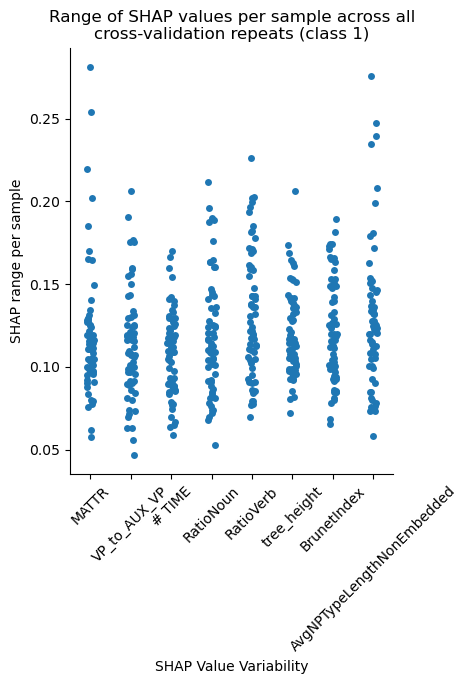

In [ ]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### AB42_AB40Positivity

In [21]:
AB42_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ab42_exp, ab42_class_0, ab42_class_1 = explain('AB42_AB40Positivity', AB42_EXP_FEATS, CV_REPETITIONS, AB42_SEEDS)

100%|██████████| 1000/1000 [14:55<00:00,  1.12it/s]


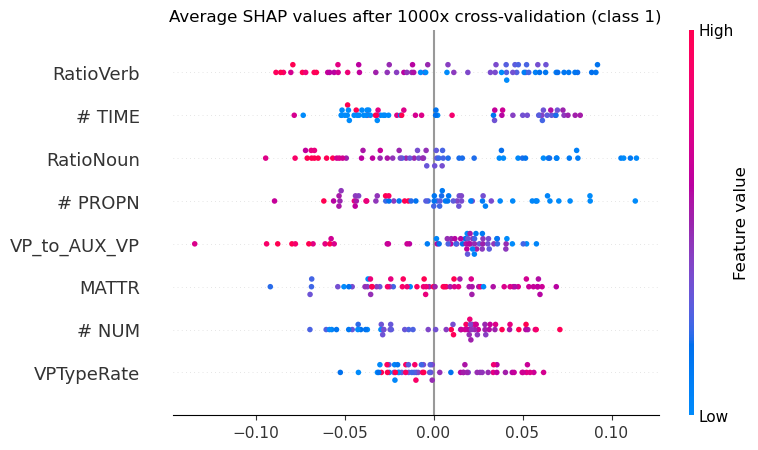

In [22]:
plot_shap_vals(X_ab42_exp, ab42_class_1[0], 1, CV_REPETITIONS)

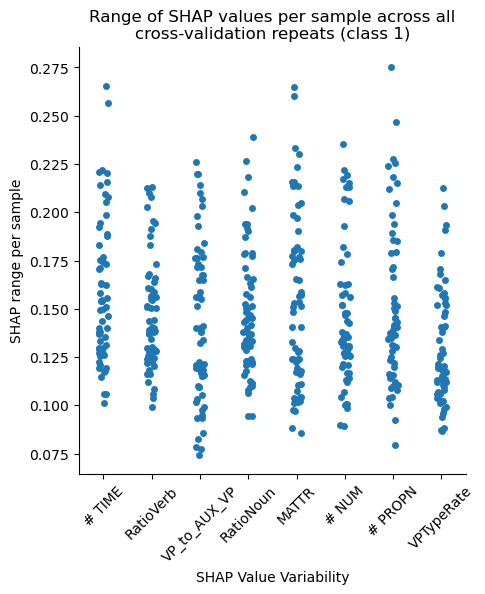

In [106]:
plot_ranges(X_ab42_exp, ab42_class_1[2], 1)

# Courpus Analysis

In [31]:
a = DATA['Age_at_testing'].tolist()
import statistics as stat
print(stat.stdev(a))

5.8386467940154185
